In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.dates import DateFormatter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read the dataset
cleaned_df = pd.read_csv('/content/drive/MyDrive/WaterVue/Ultimate_Dataframe_WaterQual.csv')
cleaned_df

Location Sample Date  Chlorophyll A  \
0           #1 HILLSBORO CANAL US 1  2006-02-28      12.100000   
1           #1 HILLSBORO CANAL US 1  2006-08-31       4.430000   
2           #1 HILLSBORO CANAL US 1  2007-02-28       2.605000   
3           #1 HILLSBORO CANAL US 1  2007-08-31      15.995000   
4           #1 HILLSBORO CANAL US 1  2008-02-29       5.925000   
...                             ...         ...            ...   
1315  #89 NOB HILL RD POMPANO CANAL  2020-02-29       3.933333   
1316  #89 NOB HILL RD POMPANO CANAL  2020-08-31       1.570000   
1317  #89 NOB HILL RD POMPANO CANAL  2021-02-28       2.966667   
1318  #89 NOB HILL RD POMPANO CANAL  2021-08-31       5.510000   
1319  #89 NOB HILL RD POMPANO CANAL  2022-02-28       2.900000   

      Dissolved Oxygen   Salinity  Specific Conductance  Total Nitrogen  \
0             6.980000  19.400000          31300.000000        0.830000   
1             5.540000  15.750000          26000.000000        0.981000   
2             6.195000  23.200000          36700.000000        0.754000   
3             6.015000  19.790000          31400.000000        0.978500   
4             5.770000  12.500000          21050.000000        1.440000   
...                ...        ...                   ...             ...   
1315          5.703333   0.310000            642.666667        1.097133   
1316          7.760000   0.250000            526.000000        0.910000   
1317          5.833333   0.233333            482.000000        0.984033   
1318          5.370000   0.270000            558.000000        1.410500   
1319          4.940000   0.290000            595.000000        1.040000   

      Total Phosphorus  Turbidity  
0             0.086000   2.400000  
1             0.109000   1.400000  
2             0.083500   1.650000  
3             0.102000   2.250000  
4             0.102000   2.050000  
...                ...        ...  
1315          0.014000   0.750000  
1316          0.011000   0.000000  
1317          0.003667   0.566667  
1318          0.049000   0.775000  
1319          0.008000   0.550000  

[1320 rows x 9 columns]

In [ ]:
# Specify the file path (adjust the path as needed)
#file_path = '/mnt/data/my_excel_file.xlsx'

# Save the DataFrame to an Excel file
#df.to_excel(file_path, index=False, engine='xlsxwriter')

#print(f"File saved to {file_path}")

In [ ]:
sorted_df = cleaned_df.sort_values(by='Sample Date', ascending=True)

In [ ]:
# Split data into train and test sets
train_data = sorted_df.iloc[:-3*cleaned_df["Location"].nunique()].sort_values(by=['Location', 'Sample Date'], ascending=True)  # Use all but the last 12 months for training
test_data = sorted_df.iloc[-3*cleaned_df["Location"].nunique():].sort_values(by=['Location', 'Sample Date'], ascending=True)   # Use the last 12 months for testing

## Chlorophyll A

In [ ]:
# Extract all parameter names
#parameters = cleaned_df.columns.tolist()[2:]  # Skip the first two columns

param = 'Chlorophyll A'

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

predictions = []

for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location][['Sample Date', param]].sort_values(by='Sample Date')

    # Normalize data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df[[param]])

    # Define the sequence length and prepare the last sequence from the training data
    sequence_length = 3
    last_sequence = train_scaled[-sequence_length:]  # Last sequence of the training data

    # Define and compile the LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model on the training data
    train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=sequence_length, batch_size=1)
    model.fit(train_generator, epochs=20, verbose=1)

    # Iteratively forecast the next 3 steps
    forecast_steps = 3
    predictions_scaled = []
    for _ in range(forecast_steps):
        # Reshape the last sequence for prediction
        last_sequence_reshaped = last_sequence.reshape((1, sequence_length, 1))
        # Predict the next step and append to predictions
        next_step_pred = model.predict(last_sequence_reshaped)
        predictions_scaled.append(next_step_pred.ravel()[0])
        # Update the last sequence with the prediction
        last_sequence = np.roll(last_sequence, -1)
        last_sequence[-1] = next_step_pred

    # Inverse transform predictions
    predictions_inv = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))

    # Prepare the forecast index; adjust as needed for your specific dates
    forecast_index = pd.date_range(start=train_df['Sample Date'].max(), periods=forecast_steps + 1, freq='4M')[1:]

    # Append predictions for the location
    predictions.append(pd.DataFrame({"Location": [location] * forecast_steps, "Sample Date": forecast_index, param: predictions_inv.flatten()}))

# Concatenate all predictions with the original data for plotting
pred_data = pd.concat(predictions)
combined_data = pd.concat([train_data.assign(Dataset='Train'), test_data.assign(Dataset='Test'), pred_data.assign(Dataset='Prediction')])

# Convert "Sample Date" to datetime for plotting
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])


Epoch 1/20
27/27 [==============================] - 2s 3ms/step - loss: 0.0940
Epoch 2/20
27/27 [==============================] - 0s 4ms/step - loss: 0.0530
Epoch 3/20
27/27 [==============================] - 0s 3ms/step - loss: 0.0429
Epoch 4/20
27/27 [==============================] - 0s 3ms/step - loss: 0.0424
Epoch 5/20
27/27 [==============================] - 0s 4ms/step - loss: 0.0431
Epoch 6/20
27/27 [==============================] - 0s 3ms/step - loss: 0.0422
Epoch 7/20
27/27 [==============================] - 0s 3ms/step - loss: 0.0430
Epoch 8/20
27/27 [==============================] - 0s 3ms/step - loss: 0.0443
Epoch 9/20
27/27 [==============================] - 0s 3ms/step - loss: 0.0417
Epoch 10/20
27/27 [==============================] - 0s 3ms/step - loss: 0.0421
Epoch 11/20
27/27 [==============================] - 0s 3ms/step - loss: 0.0428
Epoch 12/20
27/27 [==============================] - 0s 3ms/step - loss: 0.0414
Epoch 13/20
27/27 [==============================

In [ ]:
#pred_data
#combined_data

In [ ]:
print(pred_data.head())  # Assuming pred_data holds your forecasted values
print("Unique dates in forecast data:", pred_data["Sample Date"].unique())


                     Location Sample Date  Chlorophyll A
0     #1 HILLSBORO CANAL US 1  2020-12-31       5.579669
1     #1 HILLSBORO CANAL US 1  2021-04-30       5.260875
2     #1 HILLSBORO CANAL US 1  2021-08-31       5.372234
0  #10 MIDDLE RIVER E SUNRISE  2020-12-31       3.690205
1  #10 MIDDLE RIVER E SUNRISE  2021-04-30       3.527979
Unique dates in forecast data: <DatetimeArray>
['2020-12-31 00:00:00', '2021-04-30 00:00:00', '2021-08-31 00:00:00']
Length: 3, dtype: datetime64[ns]


Plotting

<Figure size 2000x1500 with 0 Axes>

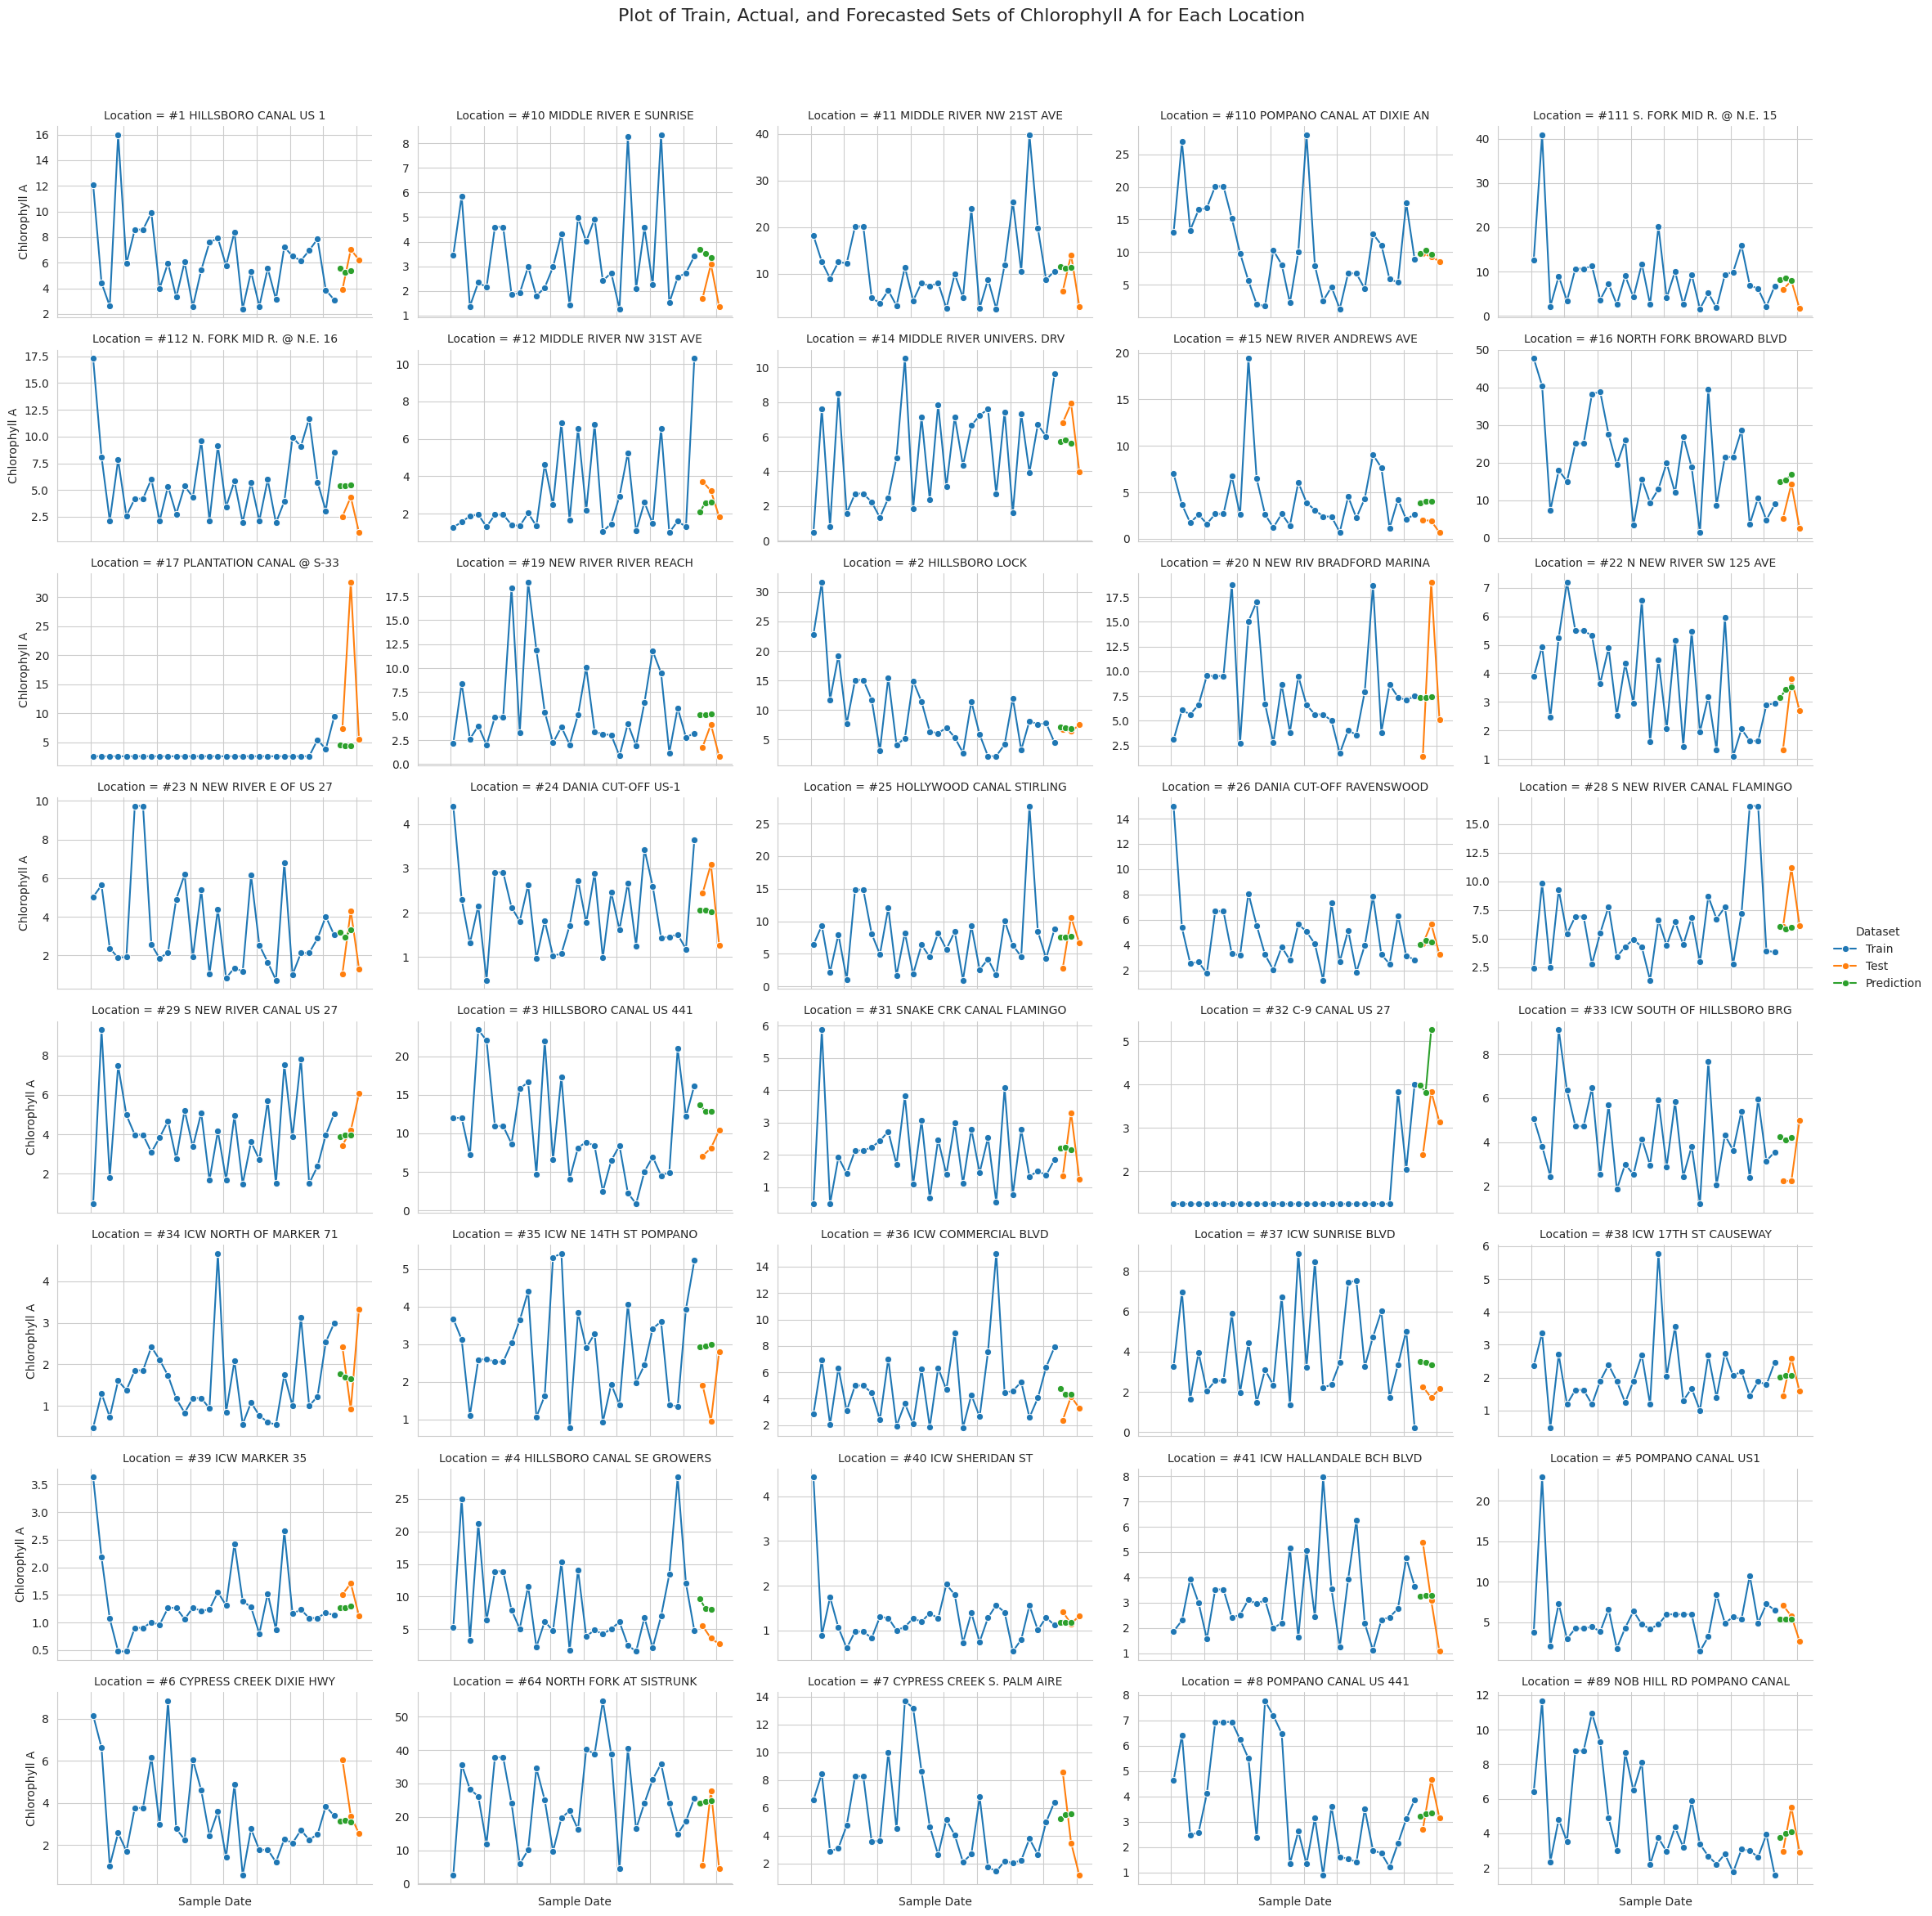

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the FacetGrid
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
# Adjust the col_wrap and size based on the number of locations and plot appearance preferences
g = sns.FacetGrid(combined_data, col="Location", hue="Dataset", col_wrap=5, height=3, aspect=1.5, sharey=False, legend_out=True)

# Map the lineplot
g = g.map(sns.lineplot, "Sample Date", "Chlorophyll A", marker="o")

# Enhance and adjust the plot aesthetics
g.add_legend()
g.set_xticklabels(rotation=45)
g.fig.subplots_adjust(top=0.92)  # Adjust the top to make space for the title if necessary
g.fig.suptitle('Plot of Train, Actual, and Forecasted Sets of Chlorophyll A for Each Location', fontsize=16)

plt.show()


In [ ]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [ ]:
accuracy.sort_values(by="RMSE", ascending=False)

## Dissolved Oxygen

In [ ]:
param = 'Dissolved Oxygen'

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as npa
import pandas as pd

predictions = []

for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location][['Sample Date', param]].sort_values(by='Sample Date')

    # Normalize data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df[[param]])

    # Define the sequence length and prepare the last sequence from the training data
    sequence_length = 2
    last_sequence = train_scaled[-sequence_length:]  # Last sequence of the training data

    # Define and compile the LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model on the training data
    train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=sequence_length, batch_size=1)
    model.fit(train_generator, epochs=20, verbose=1)

    # Iteratively forecast the next 3 steps
    forecast_steps = 3
    predictions_scaled = []
    for _ in range(forecast_steps):
        # Reshape the last sequence for prediction
        last_sequence_reshaped = last_sequence.reshape((1, sequence_length, 1))
        # Predict the next step and append to predictions
        next_step_pred = model.predict(last_sequence_reshaped)
        predictions_scaled.append(next_step_pred.ravel()[0])
        # Update the last sequence with the prediction
        last_sequence = np.roll(last_sequence, -1)
        last_sequence[-1] = next_step_pred

    # Inverse transform predictions
    predictions_inv = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))

    # Prepare the forecast index; adjust as needed for your specific dates
    forecast_index = pd.date_range(start=train_df['Sample Date'].max(), periods=forecast_steps + 1, freq='4M')[1:]

    # Append predictions for the location
    predictions.append(pd.DataFrame({"Location": [location] * forecast_steps, "Sample Date": forecast_index, param: predictions_inv.flatten()}))

# Concatenate all predictions with the original data for plotting
pred_data = pd.concat(predictions)
combined_data = pd.concat([train_data.assign(Dataset='Train'), test_data.assign(Dataset='Test'), pred_data.assign(Dataset='Prediction')])

# Convert "Sample Date" to datetime for plotting
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])


Epoch 1/20
28/28 [==============================] - 2s 3ms/step - loss: 0.1685
Epoch 2/20
28/28 [==============================] - 0s 3ms/step - loss: 0.1148
Epoch 3/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0680
Epoch 4/20
28/28 [==============================] - 0s 7ms/step - loss: 0.0423
Epoch 5/20
28/28 [==============================] - 0s 6ms/step - loss: 0.0363
Epoch 6/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0371
Epoch 7/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0373
Epoch 8/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0359
Epoch 9/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0375
Epoch 10/20
28/28 [==============================] - 0s 5ms/step - loss: 0.0381
Epoch 11/20
28/28 [==============================] - 0s 6ms/step - loss: 0.0358
Epoch 12/20
28/28 [==============================] - 0s 6ms/step - loss: 0.0357
Epoch 13/20
28/28 [==============================

<Figure size 2000x1500 with 0 Axes>

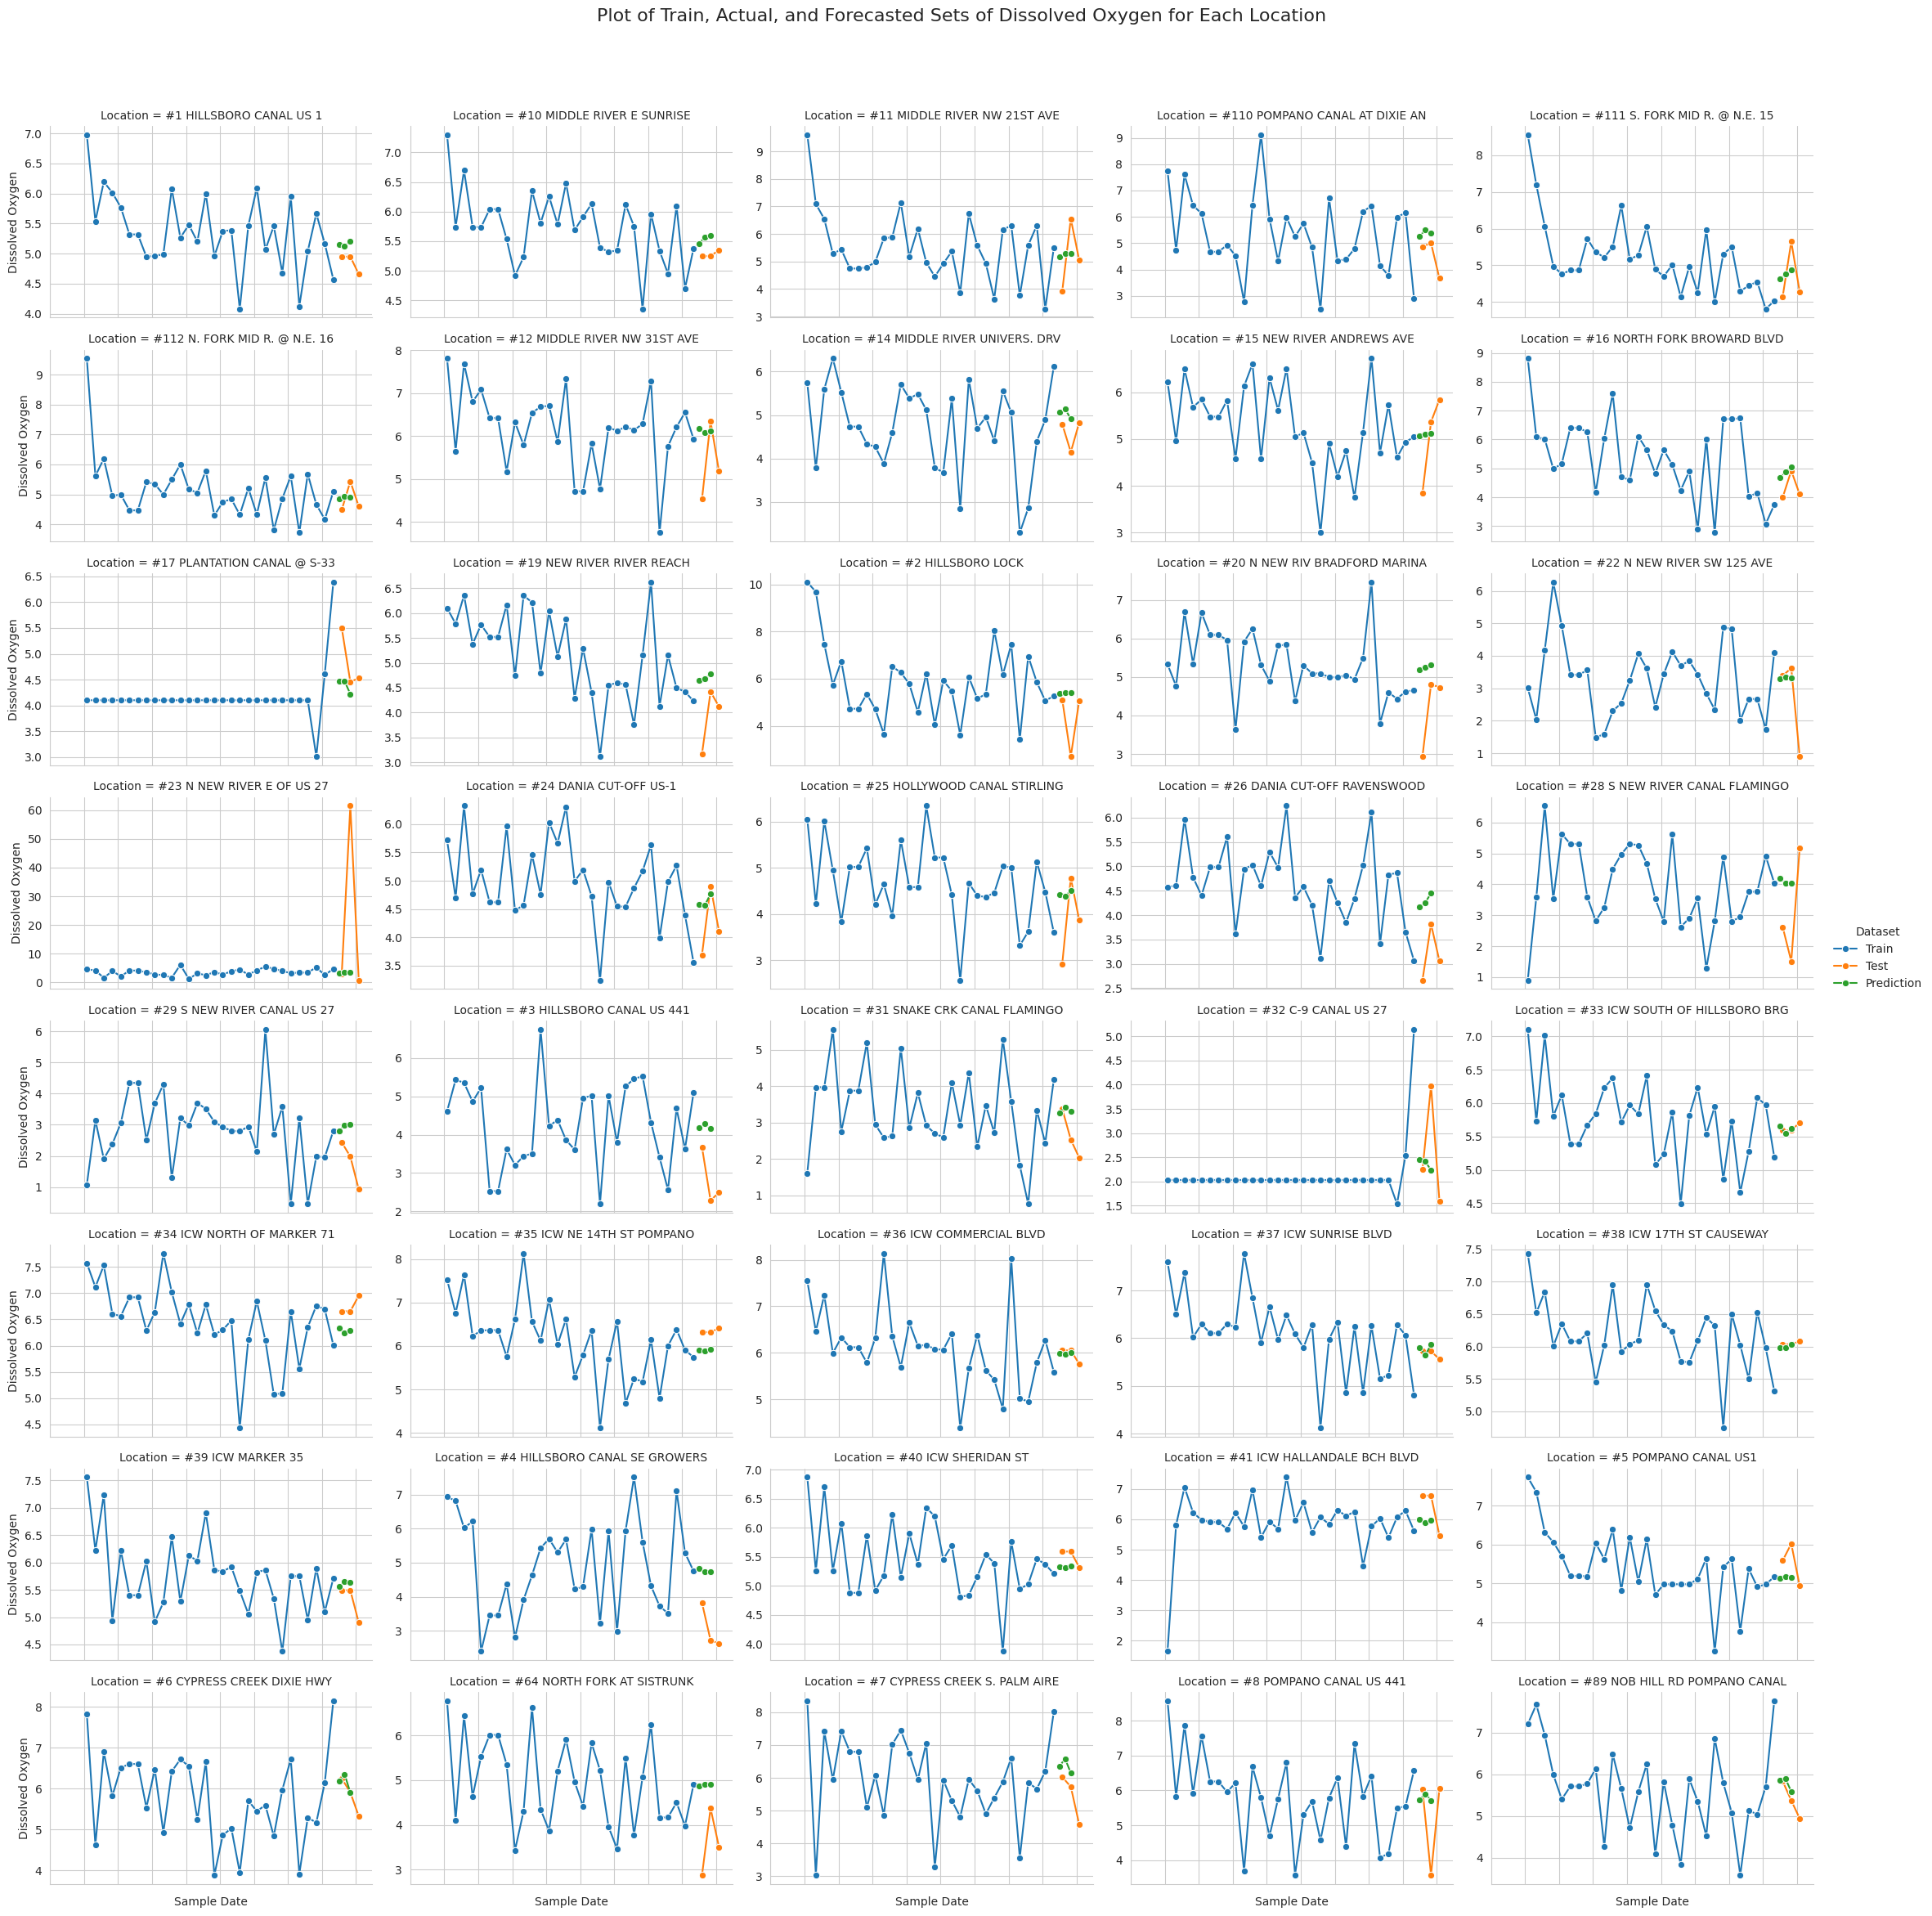

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the FacetGrid
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
# Adjust the col_wrap and size based on the number of locations and plot appearance preferences
g = sns.FacetGrid(combined_data, col="Location", hue="Dataset", col_wrap=5, height=3, aspect=1.5, sharey=False, legend_out=True)

# Map the lineplot
g = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Enhance and adjust the plot aesthetics
g.add_legend()
g.set_xticklabels(rotation=45)
g.fig.subplots_adjust(top=0.92)  # Adjust the top to make space for the title if necessary
g.fig.suptitle('Plot of Train, Actual, and Forecasted Sets of Dissolved Oxygen for Each Location', fontsize=16)

plt.show()


In [ ]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [ ]:
accuracy.sort_values(by="RMSE", ascending=False)

Location        MAE          MSE       RMSE
15      #23 N NEW RIVER E OF US 27  20.253339  1118.379796  33.442186
19  #28 S NEW RIVER CANAL FLAMINGO   1.740701     3.370078   1.835777
31   #4 HILLSBORO CANAL SE GROWERS   1.710986     3.182403   1.783929
12               #2 HILLSBORO LOCK   1.106561     2.504406   1.582532
21       #3 HILLSBORO CANAL US 441   1.393855     2.350755   1.533217
36      #64 NORTH FORK AT SISTRUNK   1.315194     2.085468   1.444115
14      #22 N NEW RIVER SW 125 AVE   0.929628     1.986774   1.409530
38         #8 POMPANO CANAL US 441   0.988487     1.883488   1.372402
13   #20 N NEW RIV BRADFORD MARINA   1.088667     1.853342   1.361375
20     #29 S NEW RIVER CANAL US 27   1.154656     1.844762   1.358220
18    #26 DANIA CUT-OFF RAVENSWOOD   1.113777     1.469664   1.212297
6     #12 MIDDLE RIVER NW 31ST AVE   0.953257     1.226100   1.107294
3   #110 POMPANO CANAL AT DIXIE AN   0.878157     1.141543   1.068430
37   #7 CYPRESS CREEK S. PALM AIRE   0.918124     1.101739   1.049637
2     #11 MIDDLE RIVER NW 21ST AVE   0.914540     1.073348   1.036025
23             #32 C-9 CANAL US 27   0.806412     0.965601   0.982650
17    #25 HOLLYWOOD CANAL STIRLING   0.837580     0.924613   0.961568
11       #19 NEW RIVER RIVER REACH   0.792861     0.884043   0.940236
22    #31 SNAKE CRK CANAL FLAMINGO   0.759677     0.817803   0.904325
8        #15 NEW RIVER ANDREWS AVE   0.733677     0.696099   0.834325
33     #41 ICW HALLANDALE BCH BLVD   0.729861     0.563183   0.750455
4    #111 S. FORK MID R. @ N.E. 15   0.655277     0.459188   0.677634
9      #16 NORTH FORK BROWARD BLVD   0.555241     0.457741   0.676566
16          #24 DANIA CUT-OFF US-1   0.626434     0.445564   0.667506
10     #17 PLANTATION CANAL @ S-33   0.449393     0.383113   0.618961
7    #14 MIDDLE RIVER UNIVERS. DRV   0.451808     0.354364   0.595285
34            #5 POMPANO CANAL US1   0.513299     0.330292   0.574710
25      #34 ICW NORTH OF MARKER 71   0.462553     0.234223   0.483966
39   #89 NOB HILL RD POMPANO CANAL   0.393968     0.228962   0.478500
26      #35 ICW NE 14TH ST POMPANO   0.443251     0.197431   0.444332
30               #39 ICW MARKER 35   0.326905     0.193538   0.439929
35      #6 CYPRESS CREEK DIXIE HWY   0.362952     0.177381   0.421167
5    #112 N. FORK MID R. @ N.E. 16   0.389308     0.158595   0.398240
0          #1 HILLSBORO CANAL US 1   0.307343     0.121950   0.349214
1       #10 MIDDLE RIVER E SUNRISE   0.262099     0.070944   0.266354
32             #40 ICW SHERIDAN ST   0.183979     0.046675   0.216044
28            #37 ICW SUNRISE BLVD   0.158195     0.036754   0.191713
27         #36 ICW COMMERCIAL BLVD   0.129050     0.023858   0.154459
24  #33 ICW SOUTH OF HILLSBORO BRG   0.068655     0.005124   0.071583
29        #38 ICW 17TH ST CAUSEWAY   0.048821     0.002393   0.048915

## Salinity

In [ ]:
param = 'Salinity'

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

predictions = []

for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location][['Sample Date', param]].sort_values(by='Sample Date')

    # Normalize data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df[[param]])

    # Define the sequence length and prepare the last sequence from the training data
    sequence_length = 2
    last_sequence = train_scaled[-sequence_length:]  # Last sequence of the training data

    # Define and compile the LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model on the training data
    train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=sequence_length, batch_size=1)
    model.fit(train_generator, epochs=20, verbose=1)

    # Iteratively forecast the next 3 steps
    forecast_steps = 3
    predictions_scaled = []
    for _ in range(forecast_steps):
        # Reshape the last sequence for prediction
        last_sequence_reshaped = last_sequence.reshape((1, sequence_length, 1))
        # Predict the next step and append to predictions
        next_step_pred = model.predict(last_sequence_reshaped)
        predictions_scaled.append(next_step_pred.ravel()[0])
        # Update the last sequence with the prediction
        last_sequence = np.roll(last_sequence, -1)
        last_sequence[-1] = next_step_pred

    # Inverse transform predictions
    predictions_inv = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))

    # Prepare the forecast index; adjust as needed for your specific dates
    forecast_index = pd.date_range(start=train_df['Sample Date'].max(), periods=forecast_steps + 1, freq='4M')[1:]

    # Append predictions for the location
    predictions.append(pd.DataFrame({"Location": [location] * forecast_steps, "Sample Date": forecast_index, param: predictions_inv.flatten()}))

# Concatenate all predictions with the original data for plotting
pred_data = pd.concat(predictions)
combined_data = pd.concat([train_data.assign(Dataset='Train'), test_data.assign(Dataset='Test'), pred_data.assign(Dataset='Prediction')])

# Convert "Sample Date" to datetime for plotting
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])


Epoch 1/20
28/28 [==============================] - 1s 3ms/step - loss: 0.3721
Epoch 2/20
28/28 [==============================] - 0s 4ms/step - loss: 0.2549
Epoch 3/20
28/28 [==============================] - 0s 4ms/step - loss: 0.1625
Epoch 4/20
28/28 [==============================] - 0s 3ms/step - loss: 0.1035
Epoch 5/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0941
Epoch 6/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0904
Epoch 7/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0913
Epoch 8/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0916
Epoch 9/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0913
Epoch 10/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0910
Epoch 11/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0874
Epoch 12/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0872
Epoch 13/20
28/28 [==============================

<Figure size 2000x1500 with 0 Axes>

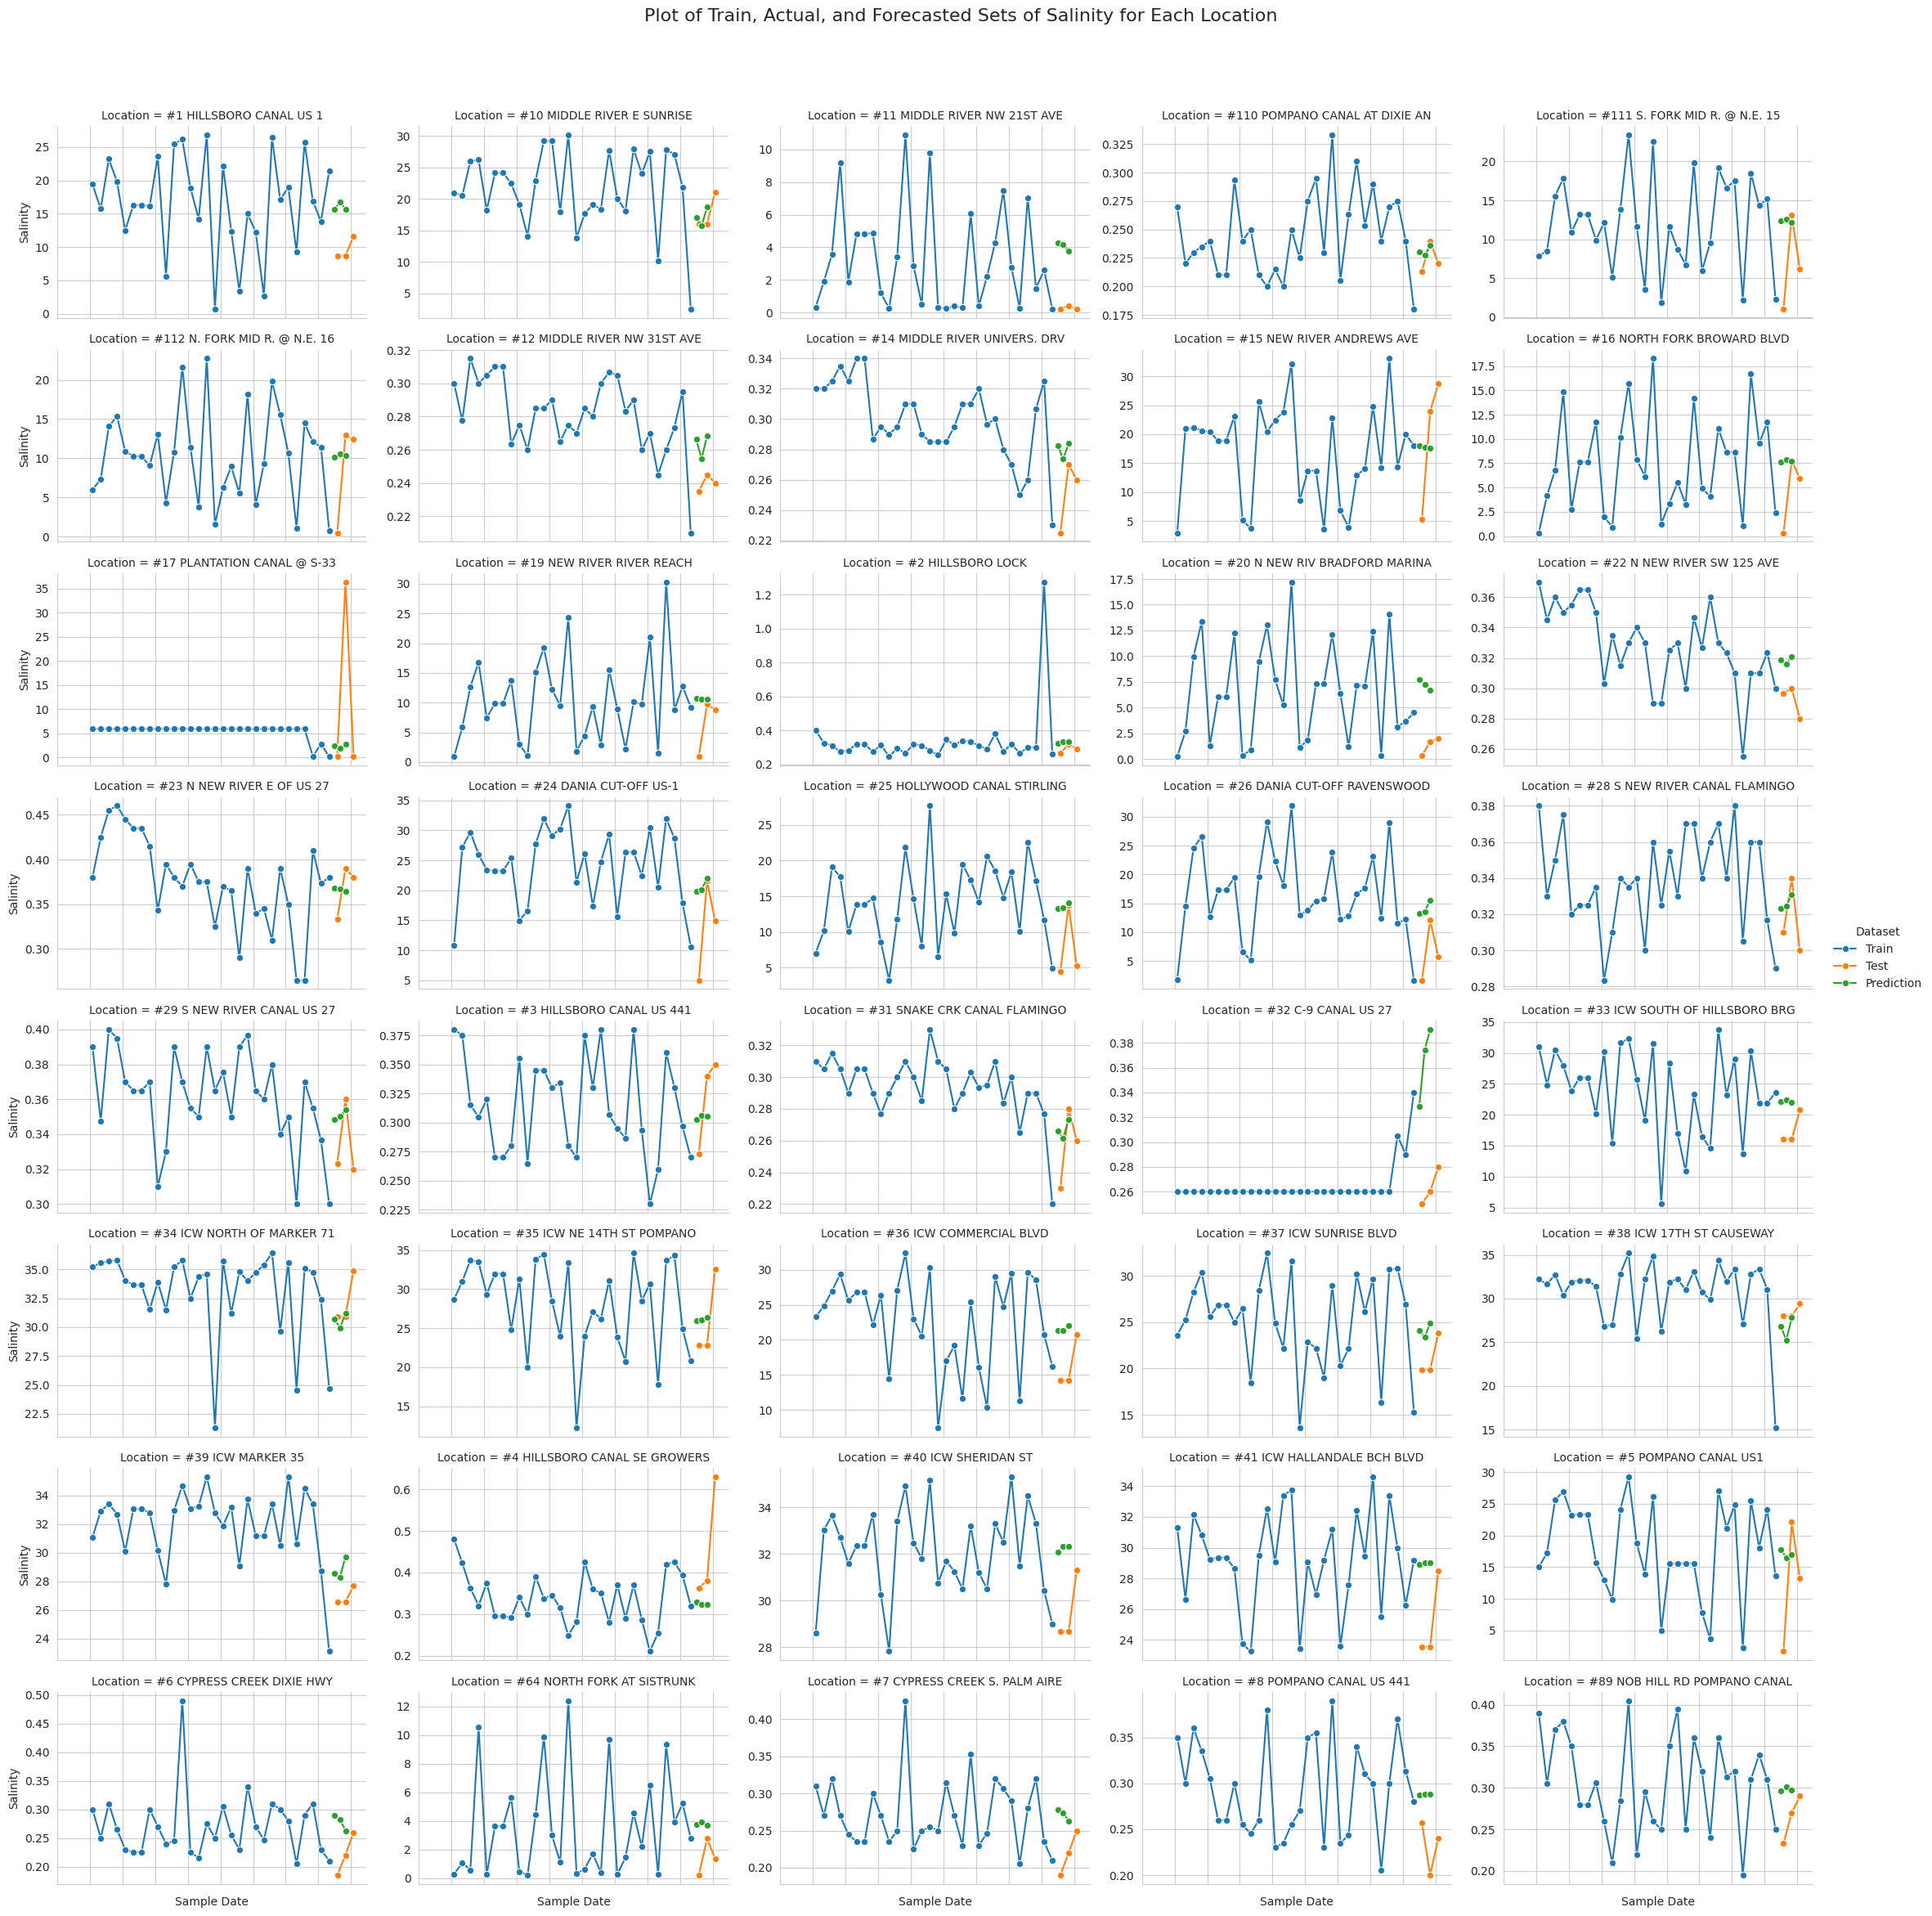

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the FacetGrid
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
# Adjust the col_wrap and size based on the number of locations and plot appearance preferences
g = sns.FacetGrid(combined_data, col="Location", hue="Dataset", col_wrap=5, height=3, aspect=1.5, sharey=False, legend_out=True)

# Map the lineplot
g = g.map(sns.lineplot, "Sample Date", "Salinity", marker="o")

# Enhance and adjust the plot aesthetics
g.add_legend()
g.set_xticklabels(rotation=45)
g.fig.subplots_adjust(top=0.92)  # Adjust the top to make space for the title if necessary
g.fig.suptitle('Plot of Train, Actual, and Forecasted Sets of Salinity for Each Location', fontsize=16)

plt.show()


In [ ]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [ ]:
accuracy.sort_values(by="RMSE", ascending=False)

Location        MAE         MSE       RMSE
10     #17 PLANTATION CANAL @ S-33  12.994609  397.121796  19.927915
8        #15 NEW RIVER ANDREWS AVE  10.048656  108.455481  10.414196
34            #5 POMPANO CANAL US1   8.499298  101.860891  10.092616
16          #24 DANIA CUT-OFF US-1   7.799580   91.154612   9.547492
18    #26 DANIA CUT-OFF RAVENSWOOD   7.641353   77.801017   8.820488
4    #111 S. FORK MID R. @ N.E. 15   5.975241   55.381362   7.441866
17    #25 HOLLYWOOD CANAL STIRLING   6.001492   52.374237   7.237005
0          #1 HILLSBORO CANAL US 1   6.370634   43.422916   6.589607
13   #20 N NEW RIV BRADFORD MARINA   5.889391   35.912224   5.992681
5    #112 N. FORK MID R. @ N.E. 16   4.721523   34.839289   5.902482
27         #36 ICW COMMERCIAL BLVD   5.144984   34.121524   5.841363
11       #19 NEW RIVER RIVER REACH   4.108998   32.983625   5.743137
24  #33 ICW SOUTH OF HILLSBORO BRG   4.560697   26.368015   5.134980
33     #41 ICW HALLANDALE BCH BLVD   3.793088   19.685682   4.436855
26      #35 ICW NE 14TH ST POMPANO   4.178445   19.471977   4.412706
9      #16 NORTH FORK BROWARD BLVD   3.064407   18.733183   4.328185
2     #11 MIDDLE RIVER NW 21ST AVE   3.771112   14.263923   3.776761
28            #37 ICW SUNRISE BLVD   2.959718   10.554844   3.248822
32             #40 ICW SHERIDAN ST   2.694731    8.684056   2.946872
36      #64 NORTH FORK AT SISTRUNK   2.345864    6.461171   2.541883
25      #34 ICW NORTH OF MARKER 71   1.647633    4.949987   2.224857
29        #38 ICW 17TH ST CAUSEWAY   1.836383    3.867008   1.966471
30               #39 ICW MARKER 35   1.911831    3.671493   1.916114
1       #10 MIDDLE RIVER E SUNRISE   1.268264    2.329477   1.526262
31   #4 HILLSBORO CANAL SE GROWERS   0.133057    0.032953   0.181529
23             #32 C-9 CANAL US 27   0.101361    0.010526   0.102597
35      #6 CYPRESS CREEK DIXIE HWY   0.056475    0.004928   0.070202
38         #8 POMPANO CANAL US 441   0.055921    0.003706   0.060874
37   #7 CYPRESS CREEK S. PALM AIRE   0.051859    0.003633   0.060272
12               #2 HILLSBORO LOCK   0.038813    0.001836   0.042854
39   #89 NOB HILL RD POMPANO CANAL   0.034023    0.001670   0.040870
21       #3 HILLSBORO CANAL US 441   0.035750    0.001319   0.036318
7    #14 MIDDLE RIVER UNIVERS. DRV   0.028403    0.001305   0.036127
14      #22 N NEW RIVER SW 125 AVE   0.026243    0.000798   0.028253
15      #23 N NEW RIVER E OF US 27   0.024451    0.000659   0.025678
6     #12 MIDDLE RIVER NW 31ST AVE   0.023089    0.000626   0.025023
20     #29 S NEW RIVER CANAL US 27   0.022901    0.000626   0.025017
22    #31 SNAKE CRK CANAL FLAMINGO   0.022742    0.000614   0.024769
19  #28 S NEW RIVER CANAL FLAMINGO   0.019813    0.000454   0.021305
3   #110 POMPANO CANAL AT DIXIE AN   0.015322    0.000238   0.015440

## Specific Conductance

In [ ]:
param = 'Specific Conductance'

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

predictions = []

for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location][['Sample Date', param]].sort_values(by='Sample Date')

    # Normalize data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df[[param]])

    # Define the sequence length and prepare the last sequence from the training data
    sequence_length = 2
    last_sequence = train_scaled[-sequence_length:]  # Last sequence of the training data

    # Define and compile the LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model on the training data
    train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=sequence_length, batch_size=1)
    model.fit(train_generator, epochs=20, verbose=1)

    # Iteratively forecast the next 3 steps
    forecast_steps = 3
    predictions_scaled = []
    for _ in range(forecast_steps):
        # Reshape the last sequence for prediction
        last_sequence_reshaped = last_sequence.reshape((1, sequence_length, 1))
        # Predict the next step and append to predictions
        next_step_pred = model.predict(last_sequence_reshaped)
        predictions_scaled.append(next_step_pred.ravel()[0])
        # Update the last sequence with the prediction
        last_sequence = np.roll(last_sequence, -1)
        last_sequence[-1] = next_step_pred

    # Inverse transform predictions
    predictions_inv = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))

    # Prepare the forecast index; adjust as needed for your specific dates
    forecast_index = pd.date_range(start=train_df['Sample Date'].max(), periods=forecast_steps + 1, freq='4M')[1:]

    # Append predictions for the location
    predictions.append(pd.DataFrame({"Location": [location] * forecast_steps, "Sample Date": forecast_index, param: predictions_inv.flatten()}))

# Concatenate all predictions with the original data for plotting
pred_data = pd.concat(predictions)
combined_data = pd.concat([train_data.assign(Dataset='Train'), test_data.assign(Dataset='Test'), pred_data.assign(Dataset='Prediction')])

# Convert "Sample Date" to datetime for plotting
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])


Epoch 1/20
28/28 [==============================] - 9s 4ms/step - loss: 0.3891
Epoch 2/20
28/28 [==============================] - 0s 4ms/step - loss: 0.2426
Epoch 3/20
28/28 [==============================] - 0s 4ms/step - loss: 0.1323
Epoch 4/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0884
Epoch 5/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0852
Epoch 6/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0842
Epoch 7/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0852
Epoch 8/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0830
Epoch 9/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0851
Epoch 10/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0833
Epoch 11/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0808
Epoch 12/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0800
Epoch 13/20
28/28 [==============================

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the FacetGrid
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
# Adjust the col_wrap and size based on the number of locations and plot appearance preferences
g = sns.FacetGrid(combined_data, col="Location", hue="Dataset", col_wrap=5, height=3, aspect=1.5, sharey=False, legend_out=True)

# Map the lineplot
g = g.map(sns.lineplot, "Sample Date", "Specific Conductance", marker="o")

# Enhance and adjust the plot aesthetics
g.add_legend()
g.set_xticklabels(rotation=45)
g.fig.subplots_adjust(top=0.92)  # Adjust the top to make space for the title if necessary
g.fig.suptitle('Plot of Train, Actual, and Forecasted Sets of Specific Conductance for Each Location', fontsize=16)

plt.show()

In [ ]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [ ]:
accuracy.sort_values(by="RMSE", ascending=False)

Location           MAE           MSE          RMSE
8        #15 NEW RIVER ANDREWS AVE  16891.753689  2.886663e+08  16990.181337
34            #5 POMPANO CANAL US1  13886.988281  2.838878e+08  16848.970990
36      #64 NORTH FORK AT SISTRUNK  10591.787055  1.813059e+08  13464.989759
18    #26 DANIA CUT-OFF RAVENSWOOD  11389.277344  1.614050e+08  12704.526615
17    #25 HOLLYWOOD CANAL STIRLING   9820.686849  1.430375e+08  11959.828080
4    #111 S. FORK MID R. @ N.E. 15   9863.685547  1.390570e+08  11792.244286
16          #24 DANIA CUT-OFF US-1  10005.077474  1.357368e+08  11650.614275
13   #20 N NEW RIV BRADFORD MARINA   9607.031141  9.599815e+07   9797.864657
0          #1 HILLSBORO CANAL US 1   9247.599609  9.531106e+07   9762.738534
5    #112 N. FORK MID R. @ N.E. 16   7716.260417  9.314123e+07   9650.970263
11       #19 NEW RIVER RIVER REACH   6555.773655  8.395066e+07   9162.459231
24  #33 ICW SOUTH OF HILLSBORO BRG   7246.457465  6.652675e+07   8156.393475
27         #36 ICW COMMERCIAL BLVD   6209.313802  5.664802e+07   7526.488191
9      #16 NORTH FORK BROWARD BLVD   4968.130208  4.916560e+07   7011.818300
2     #11 MIDDLE RIVER NW 21ST AVE   6141.949870  3.789749e+07   6156.094084
26      #35 ICW NE 14TH ST POMPANO   5876.714844  3.511629e+07   5925.900346
33     #41 ICW HALLANDALE BCH BLVD   4897.356337  3.507396e+07   5922.327182
10     #17 PLANTATION CANAL @ S-33   4458.545736  2.025431e+07   4500.479345
28            #37 ICW SUNRISE BLVD   3608.317708  1.642226e+07   4052.439120
25      #34 ICW NORTH OF MARKER 71   3099.273872  1.394404e+07   3734.171991
29        #38 ICW 17TH ST CAUSEWAY   3104.230469  1.053081e+07   3245.120519
1       #10 MIDDLE RIVER E SUNRISE   2288.272135  7.405522e+06   2721.308928
32             #40 ICW SHERIDAN ST   2432.711372  7.036551e+06   2652.649868
30               #39 ICW MARKER 35   1447.773003  2.647390e+06   1627.080223
31   #4 HILLSBORO CANAL SE GROWERS    265.648960  1.294253e+05    359.757343
23             #32 C-9 CANAL US 27    206.931776  4.367433e+04    208.984049
12               #2 HILLSBORO LOCK    121.540785  2.306765e+04    151.880371
35      #6 CYPRESS CREEK DIXIE HWY    110.284566  1.822241e+04    134.990412
38         #8 POMPANO CANAL US 441    120.521803  1.688640e+04    129.947694
37   #7 CYPRESS CREEK S. PALM AIRE    118.387451  1.688595e+04    129.945945
39   #89 NOB HILL RD POMPANO CANAL     78.419027  8.225844e+03     90.696437
7    #14 MIDDLE RIVER UNIVERS. DRV     72.662862  7.801294e+03     88.324934
21       #3 HILLSBORO CANAL US 441     66.162028  5.580488e+03     74.702662
6     #12 MIDDLE RIVER NW 31ST AVE     55.440470  3.619045e+03     60.158500
22    #31 SNAKE CRK CANAL FLAMINGO     51.321906  3.287033e+03     57.332650
3   #110 POMPANO CANAL AT DIXIE AN     48.828403  2.837139e+03     53.264803
19  #28 S NEW RIVER CANAL FLAMINGO     49.014974  2.653581e+03     51.512918
14      #22 N NEW RIVER SW 125 AVE     44.766147  2.371385e+03     48.696870
15      #23 N NEW RIVER E OF US 27     44.639038  2.140664e+03     46.267308
20     #29 S NEW RIVER CANAL US 27     35.913649  1.683545e+03     41.031024

## Total Nitrogen

In [ ]:
param = 'Total Nitrogen'

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

predictions = []

for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location][['Sample Date', param]].sort_values(by='Sample Date')

    # Normalize data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df[[param]])

    # Define the sequence length and prepare the last sequence from the training data
    sequence_length = 2
    last_sequence = train_scaled[-sequence_length:]  # Last sequence of the training data

    # Define and compile the LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model on the training data
    train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=sequence_length, batch_size=1)
    model.fit(train_generator, epochs=20, verbose=1)

    # Iteratively forecast the next 3 steps
    forecast_steps = 3
    predictions_scaled = []
    for _ in range(forecast_steps):
        # Reshape the last sequence for prediction
        last_sequence_reshaped = last_sequence.reshape((1, sequence_length, 1))
        # Predict the next step and append to predictions
        next_step_pred = model.predict(last_sequence_reshaped)
        predictions_scaled.append(next_step_pred.ravel()[0])
        # Update the last sequence with the prediction
        last_sequence = np.roll(last_sequence, -1)
        last_sequence[-1] = next_step_pred

    # Inverse transform predictions
    predictions_inv = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))

    # Prepare the forecast index; adjust as needed for your specific dates
    forecast_index = pd.date_range(start=train_df['Sample Date'].max(), periods=forecast_steps + 1, freq='4M')[1:]

    # Append predictions for the location
    predictions.append(pd.DataFrame({"Location": [location] * forecast_steps, "Sample Date": forecast_index, param: predictions_inv.flatten()}))

# Concatenate all predictions with the original data for plotting
pred_data = pd.concat(predictions)
combined_data = pd.concat([train_data.assign(Dataset='Train'), test_data.assign(Dataset='Test'), pred_data.assign(Dataset='Prediction')])

# Convert "Sample Date" to datetime for plotting
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])


Epoch 1/20
28/28 [==============================] - 1s 3ms/step - loss: 0.1541
Epoch 2/20
28/28 [==============================] - 0s 4ms/step - loss: 0.1150
Epoch 3/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0894
Epoch 4/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0769
Epoch 5/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0713
Epoch 6/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0707
Epoch 7/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0702
Epoch 8/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0709
Epoch 9/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0707
Epoch 10/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0696
Epoch 11/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0696
Epoch 12/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0701
Epoch 13/20
28/28 [==============================

<Figure size 2000x1500 with 0 Axes>

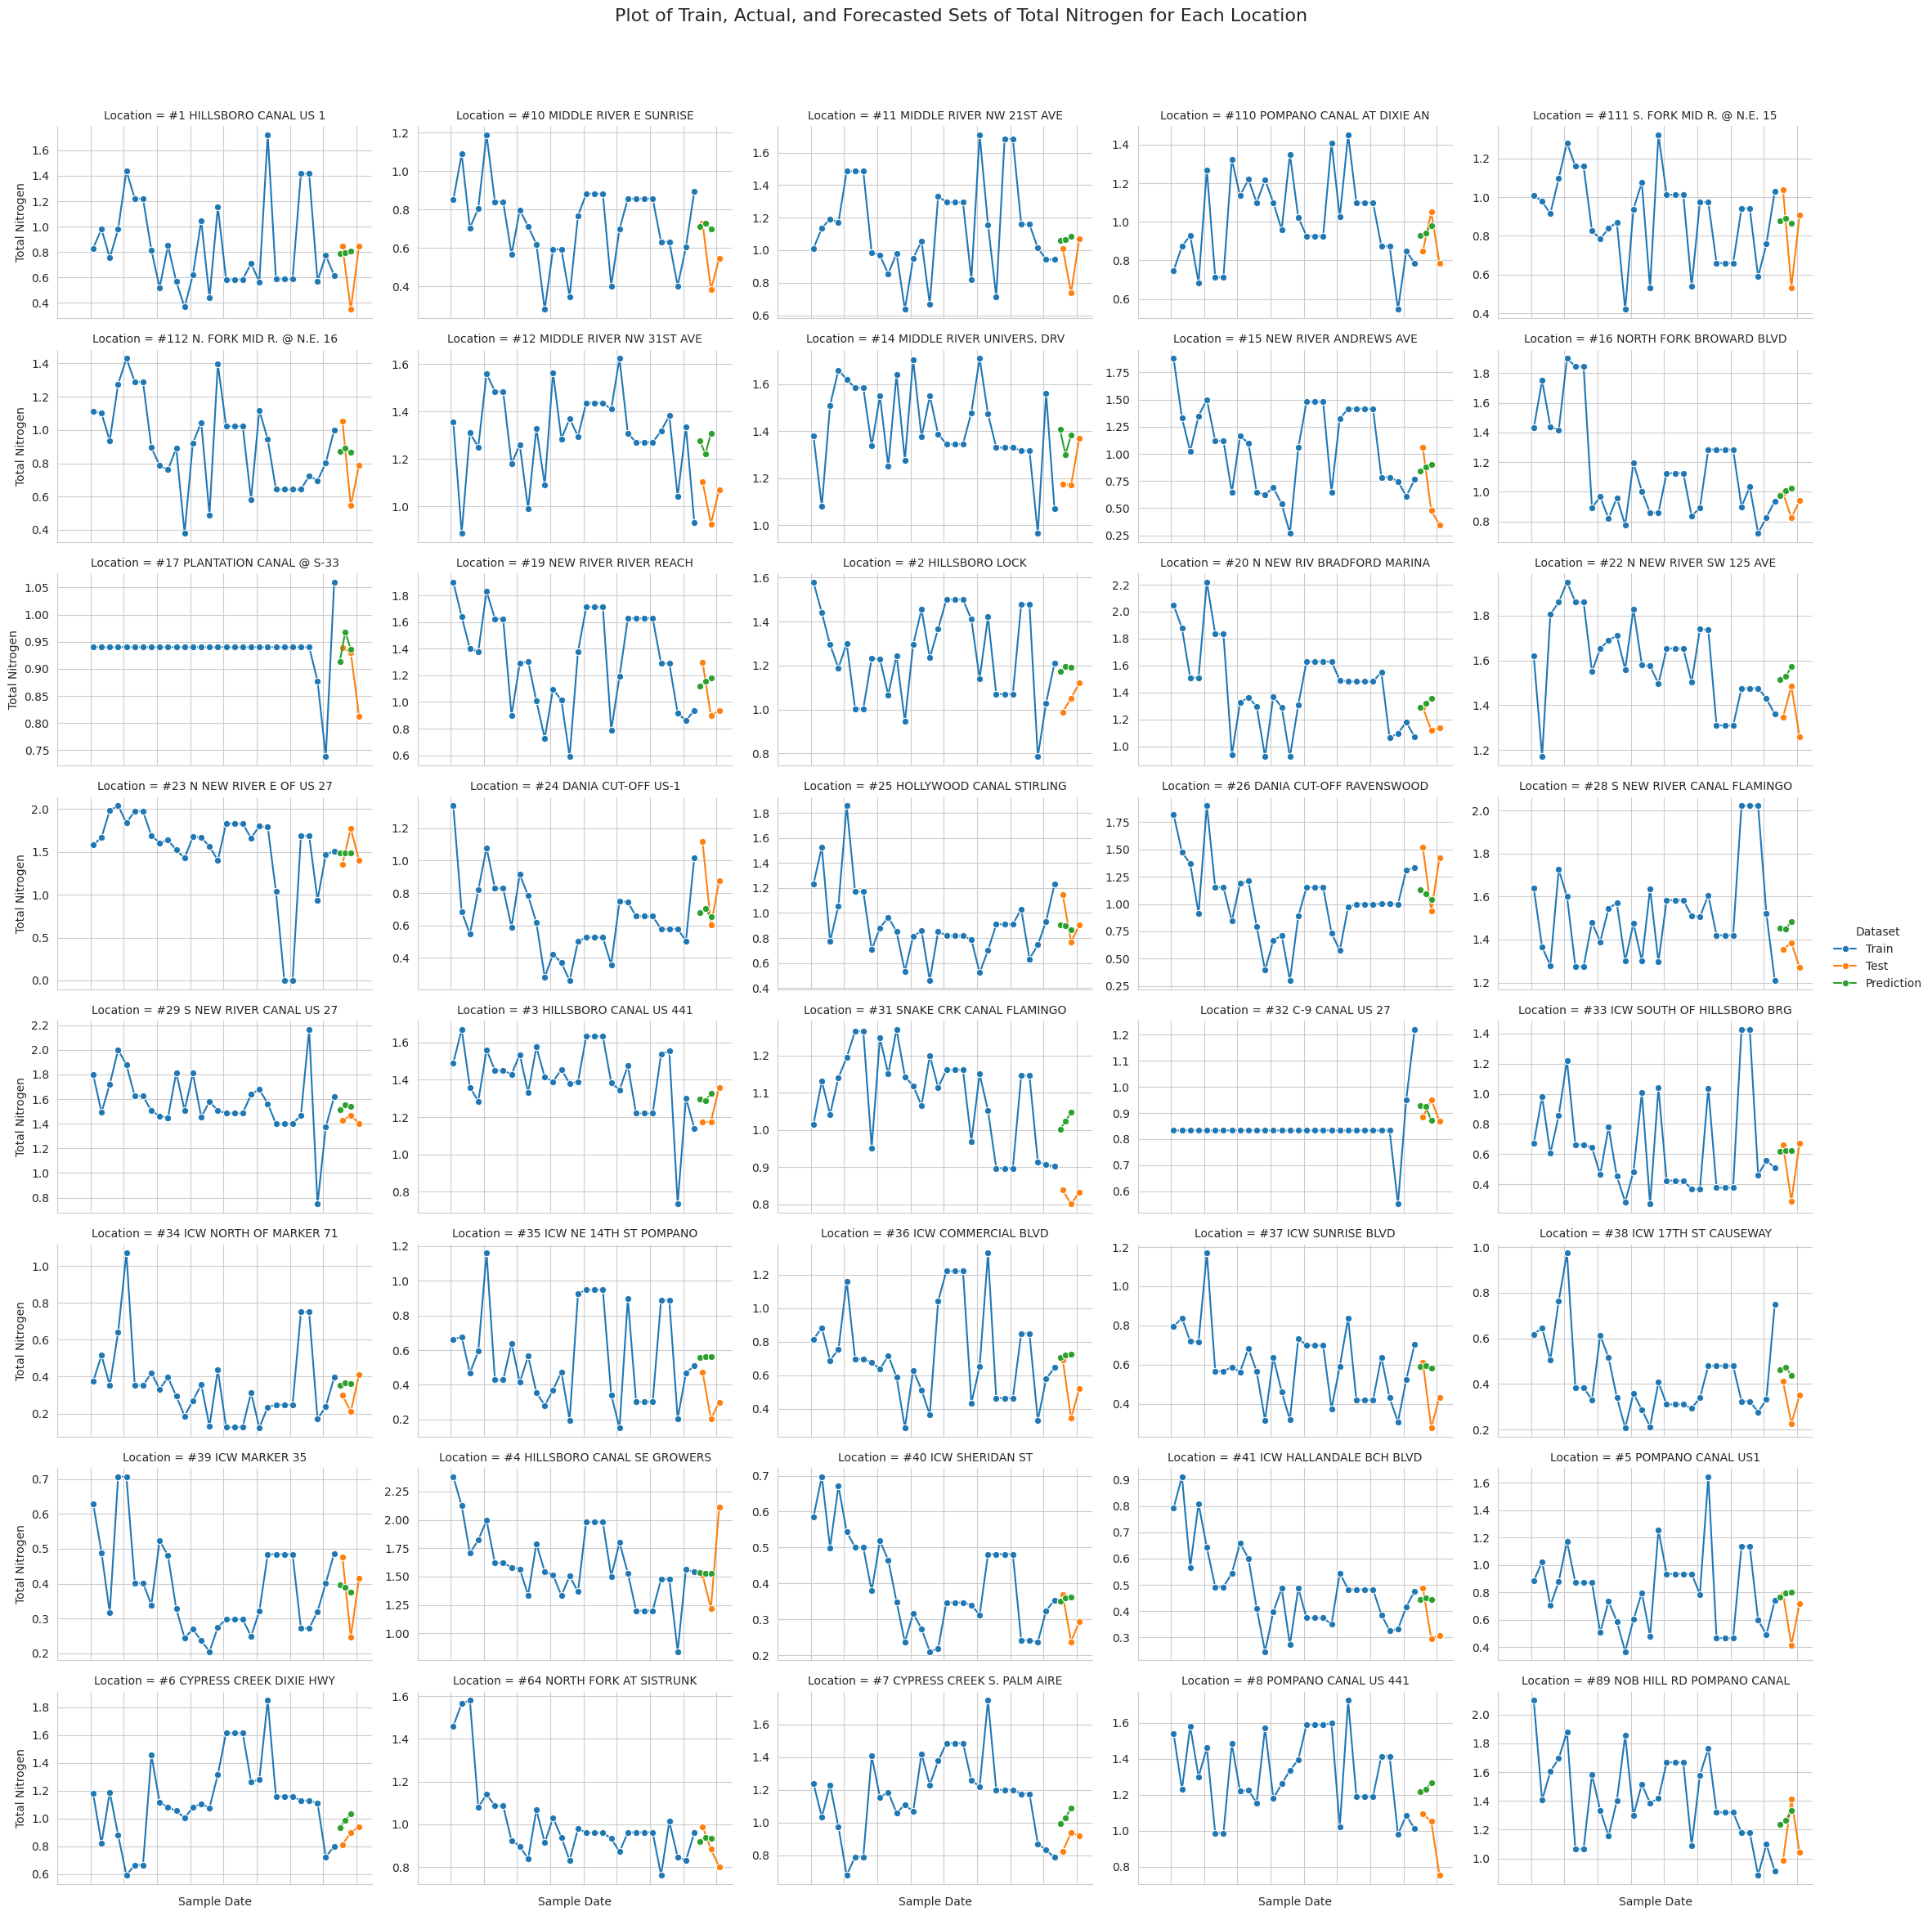

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the FacetGrid
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
# Adjust the col_wrap and size based on the number of locations and plot appearance preferences
g = sns.FacetGrid(combined_data, col="Location", hue="Dataset", col_wrap=5, height=3, aspect=1.5, sharey=False, legend_out=True)

# Map the lineplot
g = g.map(sns.lineplot, "Sample Date", "Total Nitrogen", marker="o")

# Enhance and adjust the plot aesthetics
g.add_legend()
g.set_xticklabels(rotation=45)
g.fig.subplots_adjust(top=0.92)  # Adjust the top to make space for the title if necessary
g.fig.suptitle('Plot of Train, Actual, and Forecasted Sets of Total Nitrogen for Each Location', fontsize=16)

plt.show()

In [ ]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [ ]:
accuracy.sort_values(by="RMSE", ascending=False)

## Total Phosphorus

In [ ]:
param = 'Total Phosphorus'

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

predictions = []

for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location][['Sample Date', param]].sort_values(by='Sample Date')

    # Normalize data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df[[param]])

    # Define the sequence length and prepare the last sequence from the training data
    sequence_length = 2
    last_sequence = train_scaled[-sequence_length:]  # Last sequence of the training data

    # Define and compile the LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model on the training data
    train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=sequence_length, batch_size=1)
    model.fit(train_generator, epochs=20, verbose=1)

    # Iteratively forecast the next 3 steps
    forecast_steps = 3
    predictions_scaled = []
    for _ in range(forecast_steps):
        # Reshape the last sequence for prediction
        last_sequence_reshaped = last_sequence.reshape((1, sequence_length, 1))
        # Predict the next step and append to predictions
        next_step_pred = model.predict(last_sequence_reshaped)
        predictions_scaled.append(next_step_pred.ravel()[0])
        # Update the last sequence with the prediction
        last_sequence = np.roll(last_sequence, -1)
        last_sequence[-1] = next_step_pred

    # Inverse transform predictions
    predictions_inv = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))

    # Prepare the forecast index; adjust as needed for your specific dates
    forecast_index = pd.date_range(start=train_df['Sample Date'].max(), periods=forecast_steps + 1, freq='4M')[1:]

    # Append predictions for the location
    predictions.append(pd.DataFrame({"Location": [location] * forecast_steps, "Sample Date": forecast_index, param: predictions_inv.flatten()}))

# Concatenate all predictions with the original data for plotting
pred_data = pd.concat(predictions)
combined_data = pd.concat([train_data.assign(Dataset='Train'), test_data.assign(Dataset='Test'), pred_data.assign(Dataset='Prediction')])

# Convert "Sample Date" to datetime for plotting
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])


Epoch 1/20
28/28 [==============================] - 2s 4ms/step - loss: 0.2264
Epoch 2/20
28/28 [==============================] - 0s 3ms/step - loss: 0.1814
Epoch 3/20
28/28 [==============================] - 0s 3ms/step - loss: 0.1419
Epoch 4/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0993
Epoch 5/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0708
Epoch 6/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0631
Epoch 7/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0617
Epoch 8/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0601
Epoch 9/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0619
Epoch 10/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0603
Epoch 11/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0610
Epoch 12/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0604
Epoch 13/20
28/28 [==============================

<Figure size 2000x1500 with 0 Axes>

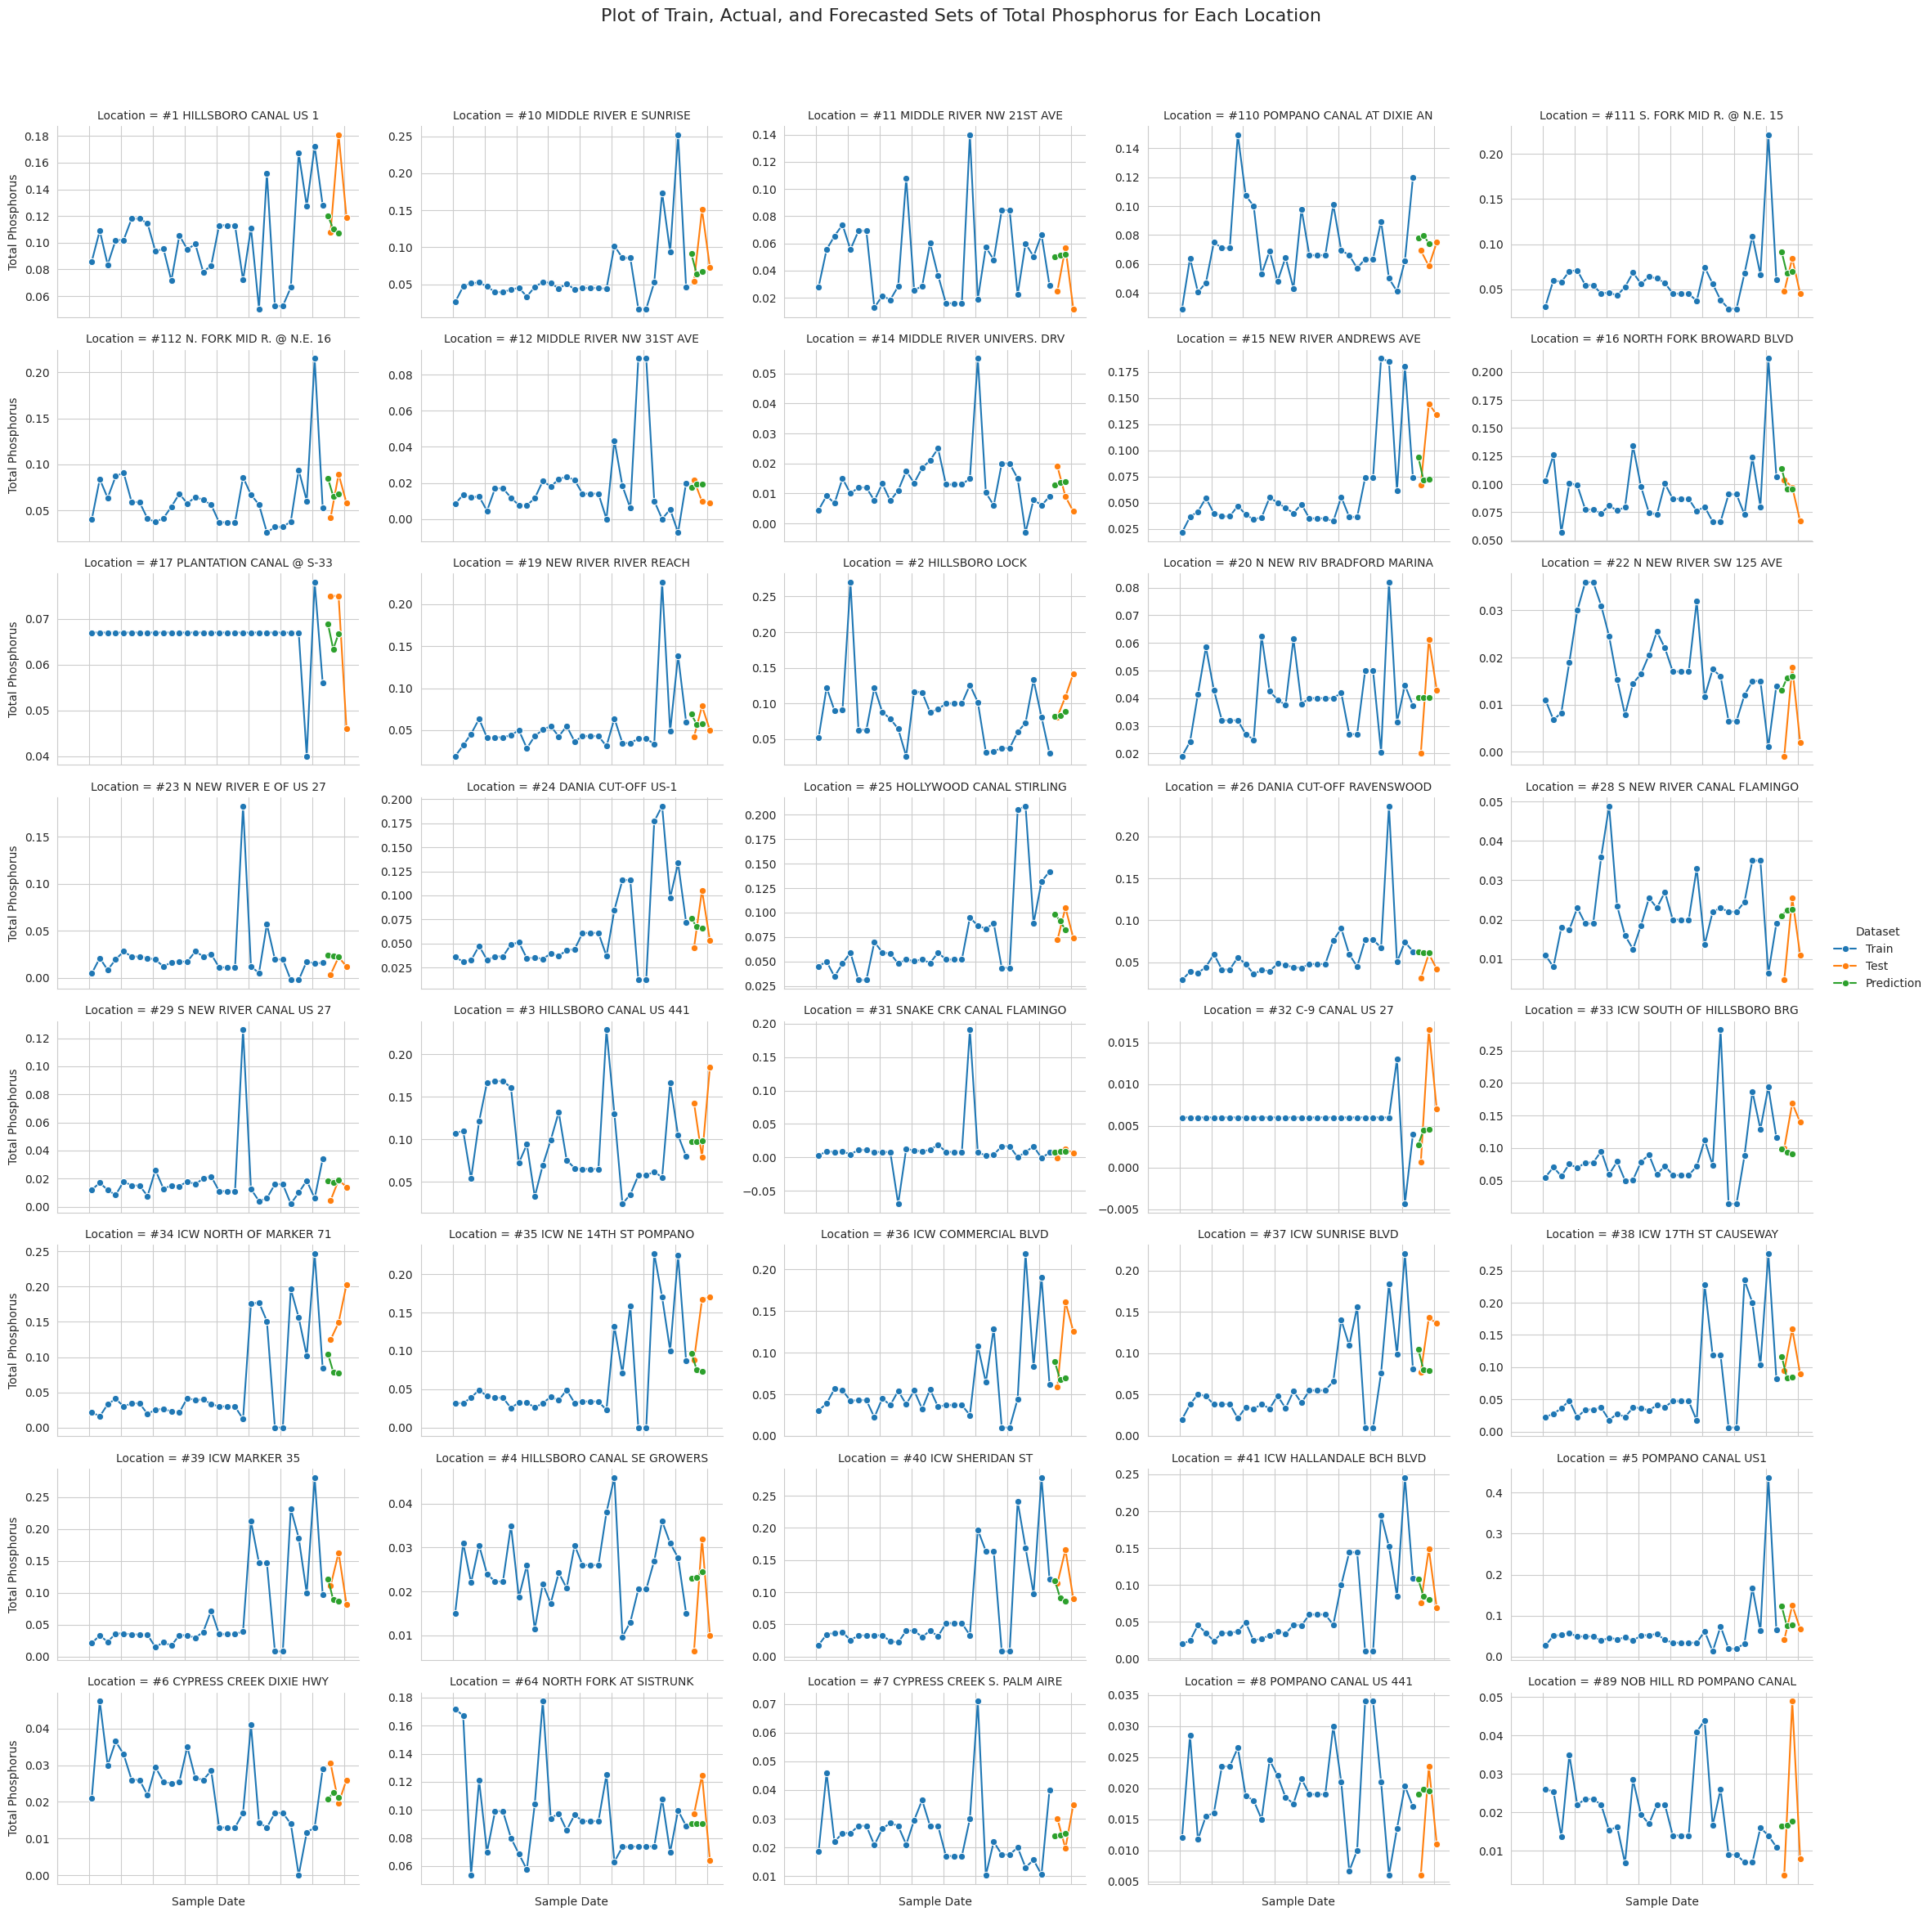

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the FacetGrid
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
# Adjust the col_wrap and size based on the number of locations and plot appearance preferences
g = sns.FacetGrid(combined_data, col="Location", hue="Dataset", col_wrap=5, height=3, aspect=1.5, sharey=False, legend_out=True)

# Map the lineplot
g = g.map(sns.lineplot, "Sample Date", "Total Phosphorus", marker="o")

# Enhance and adjust the plot aesthetics
g.add_legend()
g.set_xticklabels(rotation=45)
g.fig.subplots_adjust(top=0.92)  # Adjust the top to make space for the title if necessary
g.fig.suptitle('Plot of Train, Actual, and Forecasted Sets of Total Phosphorus for Each Location', fontsize=16)

plt.show()

In [ ]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [ ]:
accuracy.sort_values(by="RMSE", ascending=False)

Location       MAE       MSE      RMSE
25      #34 ICW NORTH OF MARKER 71  0.071773  0.006977  0.083530
26      #35 ICW NE 14TH ST POMPANO  0.065784  0.005929  0.076997
27         #36 ICW COMMERCIAL BLVD  0.059734  0.004248  0.065174
21       #3 HILLSBORO CANAL US 441  0.050255  0.003321  0.057628
8        #15 NEW RIVER ANDREWS AVE  0.053735  0.003278  0.057251
34            #5 POMPANO CANAL US1  0.047570  0.003116  0.055824
1       #10 MIDDLE RIVER E SUNRISE  0.043535  0.003010  0.054865
24  #33 ICW SOUTH OF HILLSBORO BRG  0.041971  0.002693  0.051891
28            #37 ICW SUNRISE BLVD  0.048957  0.002634  0.051322
29        #38 ICW 17TH ST CAUSEWAY  0.034414  0.002089  0.045709
30               #39 ICW MARKER 35  0.030138  0.001889  0.043461
32             #40 ICW SHERIDAN ST  0.027576  0.001863  0.043159
0          #1 HILLSBORO CANAL US 1  0.031477  0.001763  0.041988
33     #41 ICW HALLANDALE BCH BLVD  0.035879  0.001755  0.041887
12               #2 HILLSBORO LOCK  0.026767  0.001183  0.034402
4    #111 S. FORK MID R. @ N.E. 15  0.028321  0.000933  0.030541
16          #24 DANIA CUT-OFF US-1  0.027242  0.000851  0.029164
5    #112 N. FORK MID R. @ N.E. 16  0.025495  0.000824  0.028703
2     #11 MIDDLE RIVER NW 21ST AVE  0.023707  0.000759  0.027544
36      #64 NORTH FORK AT SISTRUNK  0.022565  0.000642  0.025342
18    #26 DANIA CUT-OFF RAVENSWOOD  0.017342  0.000458  0.021394
39   #89 NOB HILL RD POMPANO CANAL  0.018225  0.000432  0.020789
11       #19 NEW RIVER RIVER REACH  0.018660  0.000417  0.020415
17    #25 HOLLYWOOD CANAL STIRLING  0.016133  0.000319  0.017872
9      #16 NORTH FORK BROWARD BLVD  0.013327  0.000303  0.017401
13   #20 N NEW RIV BRADFORD MARINA  0.014710  0.000288  0.016973
10     #17 PLANTATION CANAL @ S-33  0.012852  0.000202  0.014201
31   #4 HILLSBORO CANAL SE GROWERS  0.013336  0.000189  0.013733
15      #23 N NEW RIVER E OF US 27  0.010871  0.000182  0.013487
3   #110 POMPANO CANAL AT DIXIE AN  0.010205  0.000177  0.013297
19  #28 S NEW RIVER CANAL FLAMINGO  0.010359  0.000137  0.011721
14      #22 N NEW RIVER SW 125 AVE  0.010129  0.000133  0.011517
38         #8 POMPANO CANAL US 441  0.008447  0.000086  0.009269
20     #29 S NEW RIVER CANAL US 27  0.006939  0.000073  0.008558
6     #12 MIDDLE RIVER NW 31ST AVE  0.007968  0.000071  0.008448
7    #14 MIDDLE RIVER UNIVERS. DRV  0.006952  0.000054  0.007320
37   #7 CYPRESS CREEK S. PALM AIRE  0.006897  0.000053  0.007278
23             #32 C-9 CANAL US 27  0.005482  0.000051  0.007163
35      #6 CYPRESS CREEK DIXIE HWY  0.005844  0.000043  0.006525
22    #31 SNAKE CRK CANAL FLAMINGO  0.005288  0.000036  0.006025

## Turbidity

In [ ]:
param = 'Turbidity'

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

predictions = []

for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location][['Sample Date', param]].sort_values(by='Sample Date')

    # Normalize data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df[[param]])

    # Define the sequence length and prepare the last sequence from the training data
    sequence_length = 2
    last_sequence = train_scaled[-sequence_length:]  # Last sequence of the training data

    # Define and compile the LSTM model
    model = Sequential([
        LSTM(50, activation='relu', input_shape=(sequence_length, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model on the training data
    train_generator = TimeseriesGenerator(train_scaled, train_scaled, length=sequence_length, batch_size=1)
    model.fit(train_generator, epochs=20, verbose=1)

    # Iteratively forecast the next 3 steps
    forecast_steps = 3
    predictions_scaled = []
    for _ in range(forecast_steps):
        # Reshape the last sequence for prediction
        last_sequence_reshaped = last_sequence.reshape((1, sequence_length, 1))
        # Predict the next step and append to predictions
        next_step_pred = model.predict(last_sequence_reshaped)
        predictions_scaled.append(next_step_pred.ravel()[0])
        # Update the last sequence with the prediction
        last_sequence = np.roll(last_sequence, -1)
        last_sequence[-1] = next_step_pred

    # Inverse transform predictions
    predictions_inv = scaler.inverse_transform(np.array(predictions_scaled).reshape(-1, 1))

    # Prepare the forecast index; adjust as needed for your specific dates
    forecast_index = pd.date_range(start=train_df['Sample Date'].max(), periods=forecast_steps + 1, freq='4M')[1:]

    # Append predictions for the location
    predictions.append(pd.DataFrame({"Location": [location] * forecast_steps, "Sample Date": forecast_index, param: predictions_inv.flatten()}))

# Concatenate all predictions with the original data for plotting
pred_data = pd.concat(predictions)
combined_data = pd.concat([train_data.assign(Dataset='Train'), test_data.assign(Dataset='Test'), pred_data.assign(Dataset='Prediction')])

# Convert "Sample Date" to datetime for plotting
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])


Epoch 1/20
28/28 [==============================] - 1s 3ms/step - loss: 0.0891
Epoch 2/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0698
Epoch 3/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0537
Epoch 4/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0436
Epoch 5/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0407
Epoch 6/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0405
Epoch 7/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0394
Epoch 8/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0399
Epoch 9/20
28/28 [==============================] - 0s 4ms/step - loss: 0.0393
Epoch 10/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0390
Epoch 11/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0394
Epoch 12/20
28/28 [==============================] - 0s 3ms/step - loss: 0.0396
Epoch 13/20
28/28 [==============================

<Figure size 2000x1500 with 0 Axes>

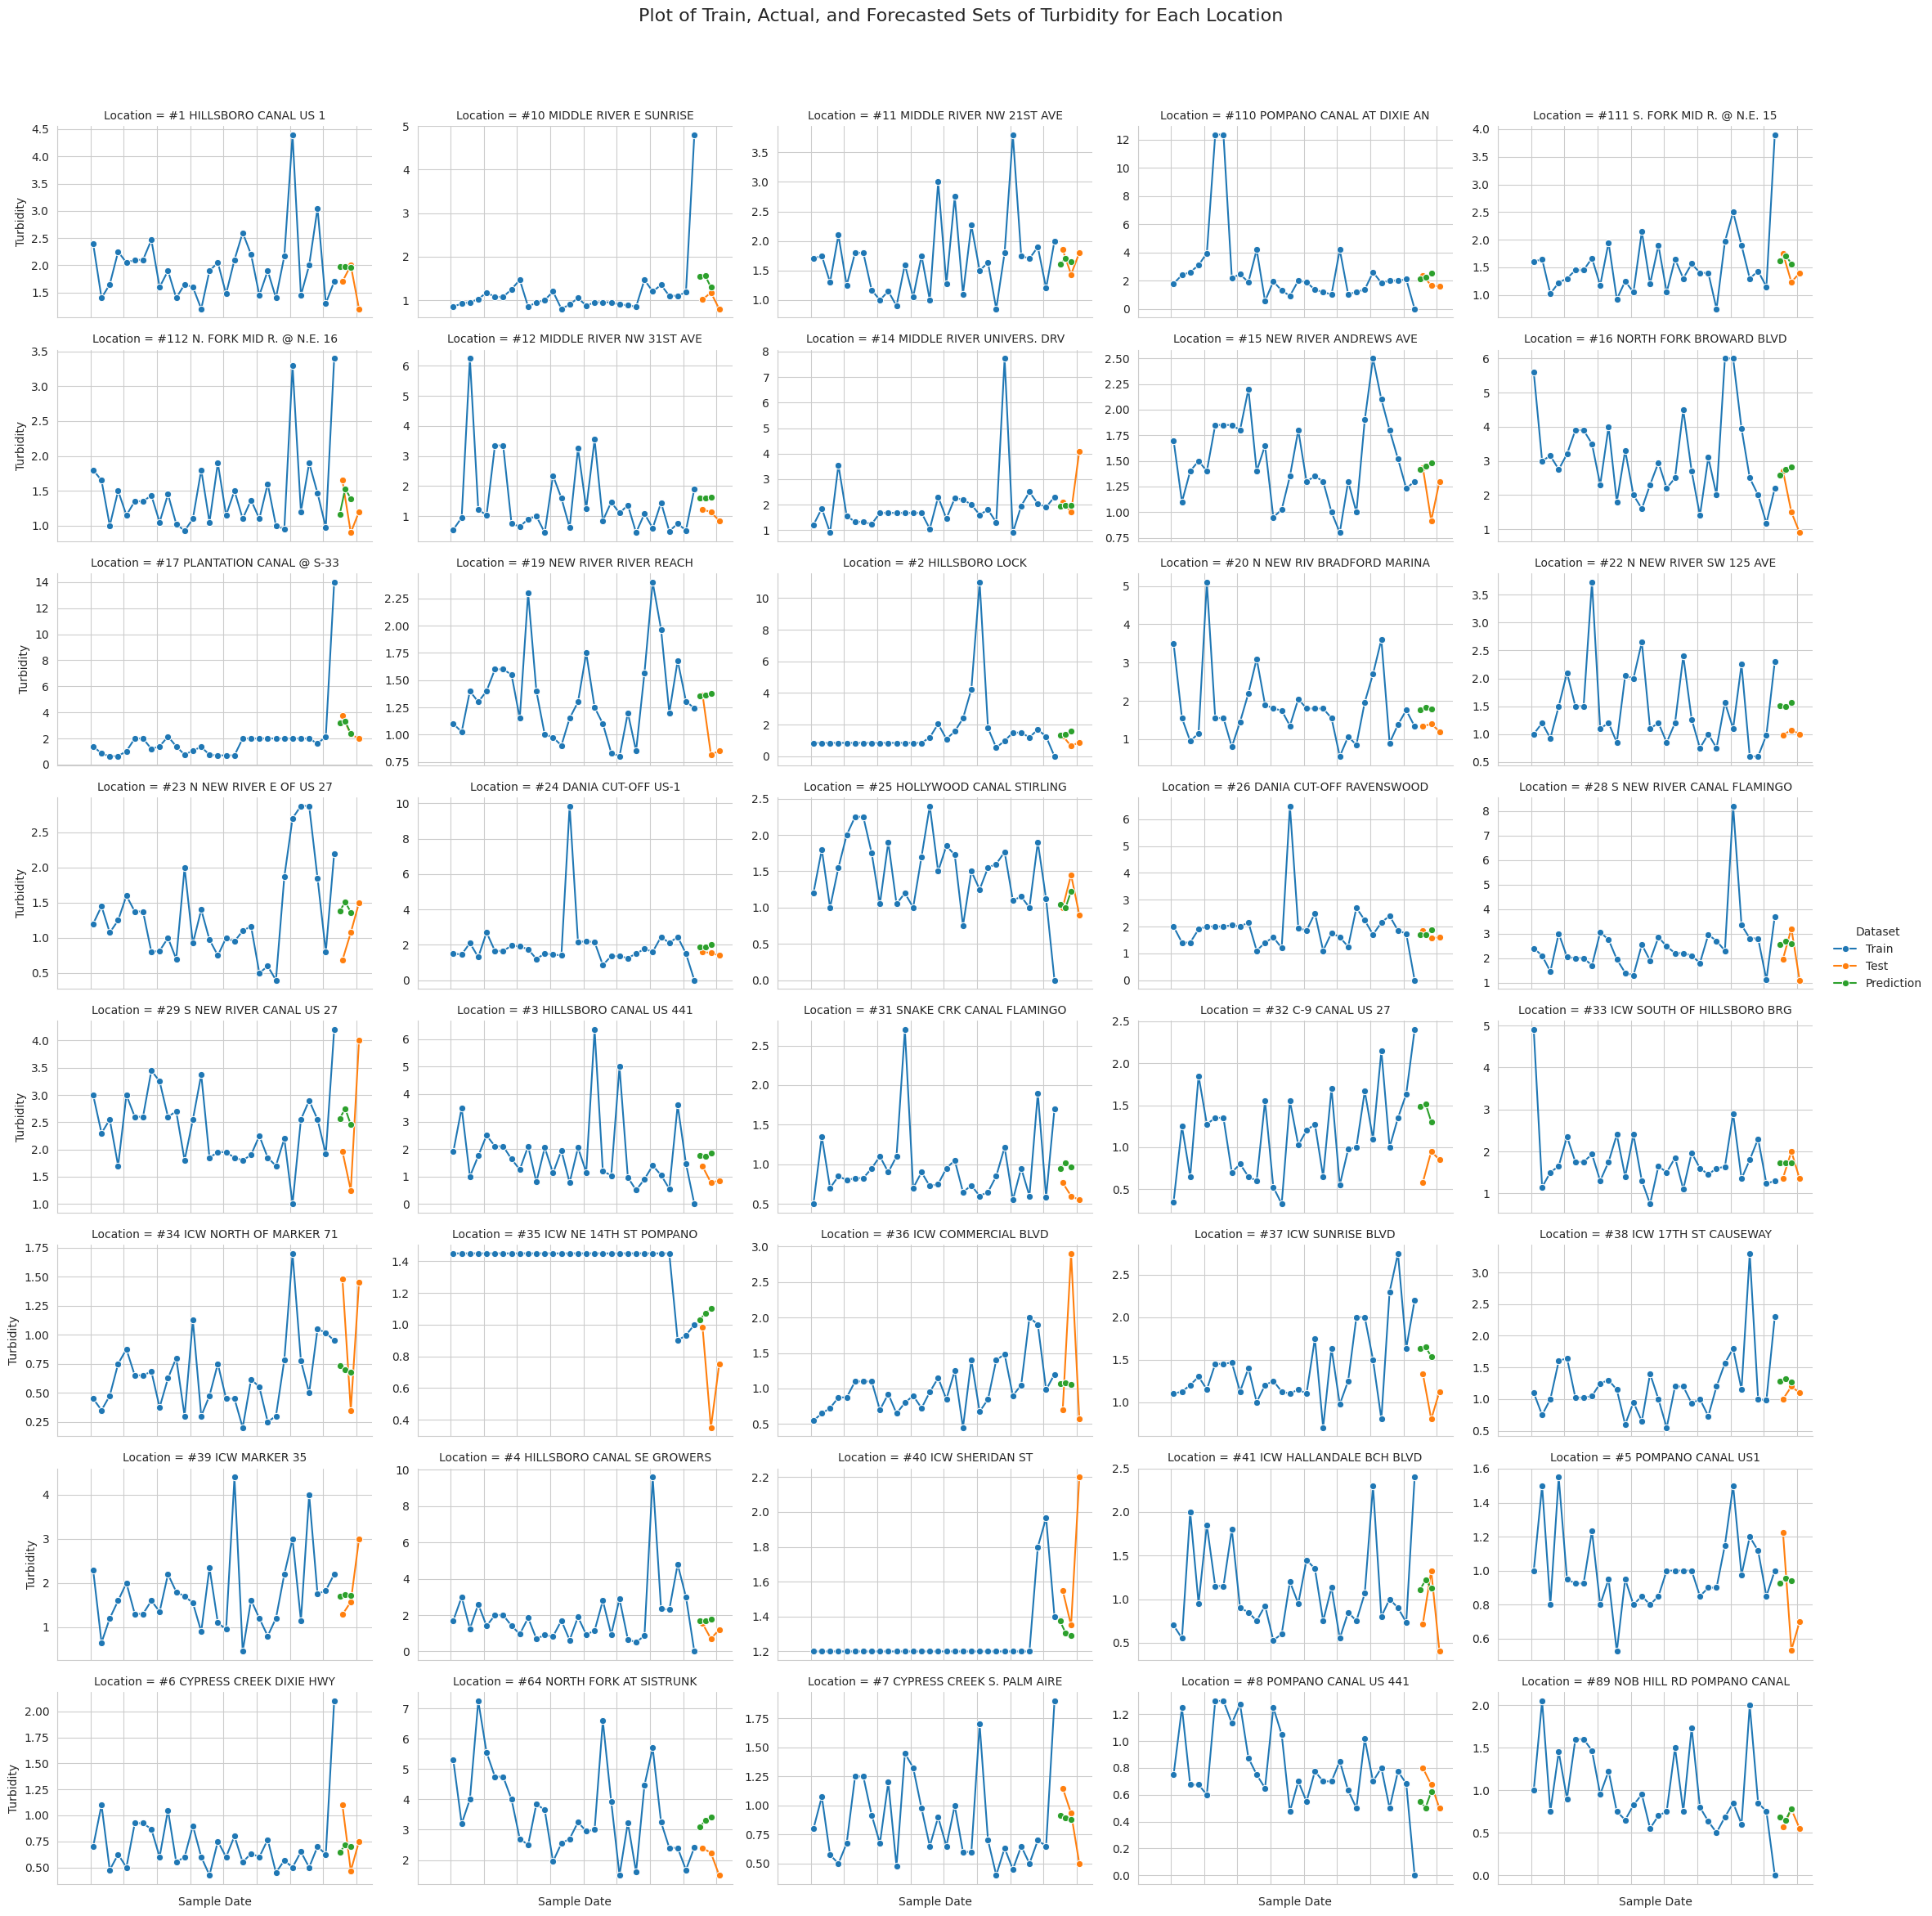

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the FacetGrid
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
# Adjust the col_wrap and size based on the number of locations and plot appearance preferences
g = sns.FacetGrid(combined_data, col="Location", hue="Dataset", col_wrap=5, height=3, aspect=1.5, sharey=False, legend_out=True)

# Map the lineplot
g = g.map(sns.lineplot, "Sample Date", "Turbidity", marker="o")

# Enhance and adjust the plot aesthetics
g.add_legend()
g.set_xticklabels(rotation=45)
g.fig.subplots_adjust(top=0.92)  # Adjust the top to make space for the title if necessary
g.fig.suptitle('Plot of Train, Actual, and Forecasted Sets of Turbidity for Each Location', fontsize=16)

plt.show()

In [ ]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [ ]:
accuracy.sort_values(by="RMSE", ascending=False)

Location       MAE       MSE      RMSE
36      #64 NORTH FORK AT SISTRUNK  1.233118  1.784345  1.335794
9      #16 NORTH FORK BROWARD BLVD  1.096433  1.747253  1.321837
20     #29 S NEW RIVER CANAL US 27  1.215187  1.665493  1.290540
7    #14 MIDDLE RIVER UNIVERS. DRV  0.850780  1.536873  1.239707
27         #36 ICW COMMERCIAL BLVD  0.890769  1.228282  1.108279
19  #28 S NEW RIVER CANAL FLAMINGO  0.866481  0.951608  0.975504
21       #3 HILLSBORO CANAL US 441  0.797039  0.709839  0.842520
30               #39 ICW MARKER 35  0.621024  0.619154  0.786864
10     #17 PLANTATION CANAL @ S-33  0.640457  0.483015  0.694993
23             #32 C-9 CANAL US 27  0.641821  0.448947  0.670035
31   #4 HILLSBORO CANAL SE GROWERS  0.570643  0.430303  0.655975
25      #34 ICW NORTH OF MARKER 71  0.623804  0.427167  0.653580
3   #110 POMPANO CANAL AT DIXIE AN  0.565670  0.400651  0.632970
12               #2 HILLSBORO LOCK  0.494023  0.350402  0.591948
28            #37 ICW SUNRISE BLVD  0.520912  0.326840  0.571699
6     #12 MIDDLE RIVER NW 31ST AVE  0.547207  0.326405  0.571319
32             #40 ICW SHERIDAN ST  0.376009  0.287008  0.535732
14      #22 N NEW RIVER SW 125 AVE  0.503520  0.257664  0.507606
13   #20 N NEW RIV BRADFORD MARINA  0.487217  0.243034  0.492984
33     #41 ICW HALLANDALE BCH BLVD  0.409329  0.232393  0.482071
15      #23 N NEW RIVER E OF US 27  0.422986  0.231451  0.481093
5    #112 N. FORK MID R. @ N.E. 16  0.436070  0.224282  0.473584
1       #10 MIDDLE RIVER E SUNRISE  0.467576  0.222446  0.471642
0          #1 HILLSBORO CANAL US 1  0.356145  0.220087  0.469135
26      #35 ICW NE 14TH ST POMPANO  0.374279  0.215782  0.464523
16          #24 DANIA CUT-OFF US-1  0.413846  0.191751  0.437893
11       #19 NEW RIVER RIVER REACH  0.360503  0.190090  0.435994
22    #31 SNAKE CRK CANAL FLAMINGO  0.339735  0.128772  0.358849
24  #33 ICW SOUTH OF HILLSBORO BRG  0.334707  0.114191  0.337921
34            #5 POMPANO CANAL US1  0.319280  0.107596  0.328018
8        #15 NEW RIVER ANDREWS AVE  0.244509  0.106596  0.326491
17    #25 HOLLYWOOD CANAL STIRLING  0.275545  0.105558  0.324896
4    #111 S. FORK MID R. @ N.E. 15  0.258213  0.091486  0.302467
35      #6 CYPRESS CREEK DIXIE HWY  0.249685  0.090136  0.300226
37   #7 CYPRESS CREEK S. PALM AIRE  0.219695  0.067126  0.259088
2     #11 MIDDLE RIVER NW 21ST AVE  0.224319  0.053258  0.230778
29        #38 ICW 17TH ST CAUSEWAY  0.190844  0.040683  0.201701
18    #26 DANIA CUT-OFF RAVENSWOOD  0.181440  0.037643  0.194019
38         #8 POMPANO CANAL US 441  0.181949  0.035846  0.189332
39   #89 NOB HILL RD POMPANO CANAL  0.158182  0.027938  0.167146

In [ ]:
# Read the dataset
rmse_df = pd.read_excel('//RMSE_LSTM.xlsx')
# Set options to display all columns and all rows
pd.set_option('display.max_columns', None)  # or specifically 40 for your case
pd.set_option('display.max_rows', None)  # This will display all rows
rmse_df

Location  Cholorophyll A  Dissolved Oxygen  \
0          #1 HILLSBORO CANAL US 1        1.488865          0.349214   
1       #10 MIDDLE RIVER E SUNRISE        1.647200          0.266354   
2     #11 MIDDLE RIVER NW 21ST AVE        5.944246          1.036025   
3   #110 POMPANO CANAL AT DIXIE AN        0.827948          1.068430   
4    #111 S. FORK MID R. @ N.E. 15        3.885212          0.677634   
5    #112 N. FORK MID R. @ N.E. 16        3.102058          0.398240   
6     #12 MIDDLE RIVER NW 31ST AVE        1.106851          1.107294   
7    #14 MIDDLE RIVER UNIVERS. DRV        1.662071          0.595285   
8        #15 NEW RIVER ANDREWS AVE        2.533200          0.834325   
9      #16 NORTH FORK BROWARD BLVD        9.994442          0.676566   
10     #17 PLANTATION CANAL @ S-33       16.371712          0.618961   
11       #19 NEW RIVER RIVER REACH        3.261037          0.940236   
12               #2 HILLSBORO LOCK        0.615096          1.582532   
13   #20 N NEW RIV BRADFORD MARINA        7.676899          1.361375   
14      #22 N NEW RIVER SW 125 AVE        1.173357          1.409530   
15      #23 N NEW RIVER E OF US 27        1.860721         33.442186   
16          #24 DANIA CUT-OFF US-1        0.768831          0.667506   
17    #25 HOLLYWOOD CANAL STIRLING        3.345887          0.961568   
18    #26 DANIA CUT-OFF RAVENSWOOD        0.951949          1.212297   
19  #28 S NEW RIVER CANAL FLAMINGO        3.062498          1.835777   
20     #29 S NEW RIVER CANAL US 27        1.243912          1.358220   
21       #3 HILLSBORO CANAL US 441        4.958469          1.533217   
22    #31 SNAKE CRK CANAL FLAMINGO        0.951316          0.904325   
23             #32 C-9 CANAL US 27        1.537154          0.982650   
24  #33 ICW SOUTH OF HILLSBORO BRG        1.653827          0.071583   
25      #34 ICW NORTH OF MARKER 71        1.124375          0.483966   
26      #35 ICW NE 14TH ST POMPANO        1.293135          0.444332   
27         #36 ICW COMMERCIAL BLVD        1.527336          0.154459   
28            #37 ICW SUNRISE BLVD        1.419831          0.191713   
29        #38 ICW 17TH ST CAUSEWAY        0.529798          0.048915   
30               #39 ICW MARKER 35        0.306514          0.439929   
31   #4 HILLSBORO CANAL SE GROWERS        4.707554          1.783929   
32             #40 ICW SHERIDAN ST        0.165965          0.216044   
33     #41 ICW HALLANDALE BCH BLVD        1.770468          0.750455   
34            #5 POMPANO CANAL US1        1.843346          0.574710   
35      #6 CYPRESS CREEK DIXIE HWY        1.726428          0.421167   
36      #64 NORTH FORK AT SISTRUNK       16.032985          1.444115   
37   #7 CYPRESS CREEK S. PALM AIRE        3.424864          1.049637   
38         #8 POMPANO CANAL US 441        0.828479          1.372402   
39   #89 NOB HILL RD POMPANO CANAL        1.205785          0.478500   
40                             NaN             NaN               NaN   
41                        RMSE < 1        9.000000         25.000000   
42                           Total       40.000000         40.000000   
43                      Percentage        0.225000          0.625000   

     Salinity  Specific Conductance  Total Nitrogen  Total Phosphorus  \
0    6.589607           9762.738534        0.261145          0.041988   
1    1.526262           2721.308928        0.218702          0.054865   
2    3.776761           6156.094084        0.192371          0.027544   
3    0.015440             53.264803        0.134774          0.013297   
4    7.441866          11792.244286        0.227074          0.030541   
5    5.902482           9650.970263        0.231321          0.028703   
6    0.025023             60.158500        0.240599          0.008448   
7    0.036127             88.324934        0.153689          0.007320   
8   10.414196          16990.181337        0.418239          0.057251   
9    4.328185           7011.818300        0.118261    